In [69]:
!pip install qiskit
!pip install tqdm
!pip install torchviz
!pip install qiskit-aer
!pip install qiskit_algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import qiskit
from qiskit import Aer, QuantumRegister, QuantumCircuit as QiskitQuantumCircuit, ClassicalRegister, transpile, assemble
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import *


from scipy.optimize import minimize
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image  # A library for image processing
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
# %matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from PIL import Image  # A library for image processing
%matplotlib inline

In [2]:
QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [20]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit.
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')
        self.theta_2 = qiskit.circuit.Parameter('theta2')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        
        self._circuit.ry(self.theta_0, 0)
        self._circuit.ry(self.theta_1, 1)
        self._circuit.ry(self.theta_2, 2)
        for i in range(n_qubits - 1):
            self._circuit.cnot(i, i + 1)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        # Convert to floats if necessary
        #thetas = [float(theta.real) for theta in thetas]
        
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots, parameter_binds=[
            {self.theta_0: thetas[0],
             self.theta_1: thetas[1],
             self.theta_2: thetas[2]}
        ])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        states = np.array(list(result.keys())).astype(float)
        expects = np.zeros(8)
        resp = np.zeros(1)
        for k in range(8):
            key = QC_outputs[k]
            expe = result.get(key, 0)
            perc = expe / self.shots

            expects[k] = perc
            resp[0] += float(key) * perc
        return resp

In [67]:
#Going to test out the quantum circuit.
sim = qiskit.Aer.get_backend('qasm_simulator')

test_circuit = QuantumCircuit(3, sim, 100000)

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2583361664.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)


In [68]:
#Heck yeah it works! It outputs the distributions of the outputs
test_circuit.run([1,2,1]), test_circuit._circuit.draw()   

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2583361664.py:39: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


(array([84.38503]),
         ┌───┐ ░ ┌────────────┐           ░ ┌─┐      
    q_0: ┤ H ├─░─┤ Ry(theta0) ├──■────────░─┤M├──────
         ├───┤ ░ ├────────────┤┌─┴─┐      ░ └╥┘┌─┐   
    q_1: ┤ H ├─░─┤ Ry(theta1) ├┤ X ├──■───░──╫─┤M├───
         ├───┤ ░ ├────────────┤└───┘┌─┴─┐ ░  ║ └╥┘┌─┐
    q_2: ┤ H ├─░─┤ Ry(theta2) ├─────┤ X ├─░──╫──╫─┤M├
         └───┘ ░ └────────────┘     └───┘ ░  ║  ║ └╥┘
 meas: 3/════════════════════════════════════╩══╩══╩═
                                             0  1  2 )

In [4]:
def to_numbers(input):
    parameter = []

    #A very scrapy but functional way of loading the parameters in this format
    for x in input:
        for y in x:
            parameter.append(float(y))
    return parameter

In [16]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Convert input to float and ensure no complex values
        #input_floats = [float(x) for x in to_numbers(input)]
        #expectation_z = ctx.quantum_circuit.run(input_floats)
        expectation_z = ctx.quantum_circuit.run(to_numbers(input))

        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        #print("input:", input, " expectation_z:", expectation_z)
        
        input_list = list(input)[0]

        gradients = torch.Tensor()

        for i in range(3):
            shift_right = np.array(input_list.detach().clone())
            shift_left = np.array(input_list.detach().clone())

            shift_right[i] = float(shift_right[i] + ctx.shift)
            shift_left[i] = float(shift_left[i] - ctx.shift)

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        gradients = gradients.T
        resp = gradients.float() * grad_output.float().T
        return resp, None, None


In [6]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift, n_qubits):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.quantum_circuit._circuit.draw()
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [12]:
class Net(nn.Module):
    def __init__(self, n_qubits):
        super(Net, self).__init__()
        # Definiendo todas las capas clásicas
        self.classical = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d()
        )
        
        # Definiendo la parte intermedia
        self.middel = nn.Sequential(
            nn.Linear(20 * 5 * 5, 500),  # Ajustar el tamaño del tensor adecuadamente
            nn.ReLU(),
            nn.Linear(500, n_qubits)
        )
        
        # Definiendo la parte cuántica
        self.quantum = Hybrid(Aer.get_backend('qasm_simulator'), 1000, 0, n_qubits=n_qubits)
        
        # Definiendo la parte final de las capas clásicas
        self.end = nn.Sequential(
            nn.Linear(8, 5),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.classical(x)
        x = x.view(x.size(0), -1)  # Ajuste para el tamaño del batch
        
        # Pasar a través de la parte intermedia
        x = self.middel(x)
        
        # Pasar a través de la parte cuántica
        x = self.quantum(x)
        
        # Pasar a través de la parte final clásica
       # x = self.end(x.float())
        #x = x.view(1, -1)
        # Retornar la salida final
        return torch.cat((x, 1 - x), -1)
    
#learning sheduller, batch normalization, profundidad, LICyRELU

In [8]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom dataset
custom_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Training', transform=transform)

# Extract labels and filter the dataset
labels = custom_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the dataset with the filtered labels and samples
custom_dataset.targets = labels[selected_indices]
custom_dataset.samples = [custom_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=1, shuffle=True)

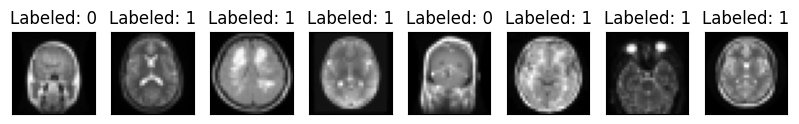

In [9]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [10]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom test dataset
custom_test_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Testing', transform=transform)

# Extract labels and filter the test dataset
labels = custom_test_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the test dataset with the filtered labels and samples
custom_test_dataset.targets = labels[selected_indices]
custom_test_dataset.samples = [custom_test_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your test dataset
test_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=1, shuffle=True)

In [82]:
from qiskit_algorithms.optimizers import COBYLA
'''
def fitness_cost(parameters):
    # Refefencia a tu circuito cuantico
    qc = QuantumCircuit(3) # Llamar de algun lugar
    qc.set_parameters(parameters) #Buscar como se setean los parametros
    
    backend.run()
    job = backend.run().jobs()
    result = job.result()
    score = # Encontrar el valor esperado 
            # freq = {'01111':4, '11010':6}
            # acum = np.zeros(num_qubits)
            # sz = 0
            # for key,val in freq.items():
            #  sz += val
            #  for i,bin in enumerate(key):
            #    acum[i] += to_int(bin)
            # acum /= sz
            #
            # Verificar que tan bien le fue:
            # si el modelo fue pensado en encontrar la energia mímima
            #   se retorna el valor esperado
            # Caso contrario, me parece que, junto a parametros, se debe
            # colocar el valor deseado para comparlo con el esperado
    return score
 
    optimizer = COBYLA(maxiter=100)
    model_ = optimizer.minimize(fun=fitness_cost, x0=[0]*3 )
    print(model_)
    print("Best values:", model_.x)
    exit()
    '''

'\ndef fitness_cost(parameters):\n    # Refefencia a tu circuito cuantico\n    qc = QuantumCircuit(3) # Llamar de algun lugar\n    qc.set_parameters(parameters) #Buscar como se setean los parametros\n    \n    backend.run()\n    job = backend.run().jobs()\n    result = job.result()\n    score = # Encontrar el valor esperado \n            # freq = {\'01111\':4, \'11010\':6}\n            # acum = np.zeros(num_qubits)\n            # sz = 0\n            # for key,val in freq.items():\n            #  sz += val\n            #  for i,bin in enumerate(key):\n            #    acum[i] += to_int(bin)\n            # acum /= sz\n            #\n            # Verificar que tan bien le fue:\n            # si el modelo fue pensado en encontrar la energia mímima\n            #   se retorna el valor esperado\n            # Caso contrario, me parece que, junto a parametros, se debe\n            # colocar el valor deseado para comparlo con el esperado\n    return score\n \n    optimizer = COBYLA(maxiter=10

In [21]:
model = Net(n_qubits = 3)

optimizer = optim.Adam(model.parameters(), lr=0.1)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            print(output)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


C:\Users\Sergio\AppData\Local\Temp\ipykernel_24216\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_24216\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 52.3260
tensor([[ 58.0760, -57.0760]], dtype=torch.float64)
tensor([[ 57.9560, -56.9560]], dtype=torch.float64)
tensor([[ 55.4590, -54.4590]], dtype=torch.float64)
tensor([[ 56.7790, -55.7790]], dtype=torch.float64)
tensor([[ 58.1290, -57.1290]], dtype=torch.float64)
tensor([[ 56.9700, -55.9700]], dtype=torch.float64)
tensor([[ 55.6510, -54.6510]], dtype=torch.float64)
tensor([[ 56.8070, -55.8070]], dtype=torch.float64)
tensor([[ 56.0470, -55.0470]], dtype=torch.float64)
tensor([[ 55.4490, -54.4490]], dtype=torch.float64)
tensor([[ 57.3940, -56.3940]], dtype=torch.float64)
tensor([[ 56.8760, -55.8760]], dtype=torch.float64)
tensor([[ 58.0400, -57.0400]], dtype=torch.float64)
tensor([[ 54.6160, -53.6160]], dtype=torch.float64)
tensor([[ 56.6590, -55.6590]], dtype=torch.float64)
tensor([[ 55.4270, -54.4270]], dtype=torch.float64)
tensor([[ 57.1300, -56.1300]], dtype=torch.float64)
tensor([[ 57.7050, -56.7050]], dtype=torch.float64)
tensor([[ 57.7850, -56.

KeyboardInterrupt: 

C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 37.3122
Epoch [1/5]	Validation	Loss: 11.7904	Validation Accuracy: 54.0%
Epoch [2/5]	Training [40%]	Loss: 15.0786
Epoch [2/5]	Validation	Loss: 7.7142	Validation Accuracy: 56.0%
Epoch [3/5]	Training [60%]	Loss: 15.4452
Epoch [3/5]	Validation	Loss: 5.9688	Validation Accuracy: 57.5%
Epoch [4/5]	Training [80%]	Loss: 11.8567
Epoch [4/5]	Validation	Loss: 7.7580	Validation Accuracy: 54.0%
Epoch [5/5]	Training [100%]	Loss: 14.4215
Epoch [5/5]	Validation	Loss: 4.2674	Validation Accuracy: 58.5%
Rendimiento del test data:
	Loss: 4.2674
	Accuracy: 58.5%
	precision: 77.3%
	recall: 58.5%
	f_score: 49.9%
(0.7732240437158471, 0.585, 0.49865603575850925, None)

Confusion Matrix:
[[100   0]
 [ 83  17]]


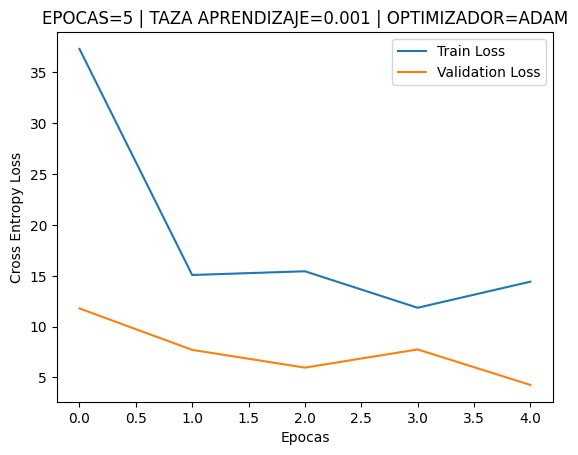

In [150]:
model = Net(n_qubits = 3)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4095975154.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.

Epoch [1/5]	Training [20%]	Loss: 54.4575
Epoch [1/5]	Validation	Loss: 71.7800	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 11.9050
Epoch [2/5]	Validation	Loss: 108.6188	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 19.3609
Epoch [3/5]	Validation	Loss: 51.7061	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 13.8270
Epoch [4/5]	Validation	Loss: 96.4184	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 8.5457
Epoch [5/5]	Validation	Loss: 1.0866	Validation Accuracy: 50.0%
Rendimiento del test data:
	Loss: 1.0866
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


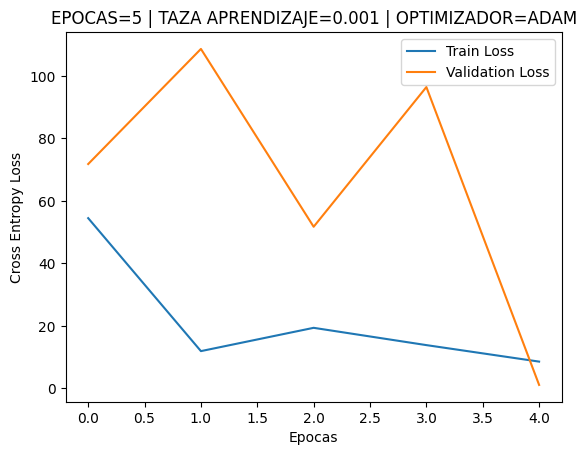

In [16]:
model = Net(n_qubits = 3)

optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


In [17]:
num_qubits = 3

**Ahora entrenemos la red**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

--------------------------------EMPEZAMOSS----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 44.5614
Epoch [1/5]	Validation	Loss: 54.5730	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 57.7514
Epoch [2/5]	Validation	Loss: 53.3913	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 51.2567
Epoch [3/5]	Validation	Loss: 57.9083	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 49.3164
Epoch [4/5]	Validation	Loss: 56.8061	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 53.1507
Epoch [5/5]	Validation	Loss: 56.0420	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 56.0420
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


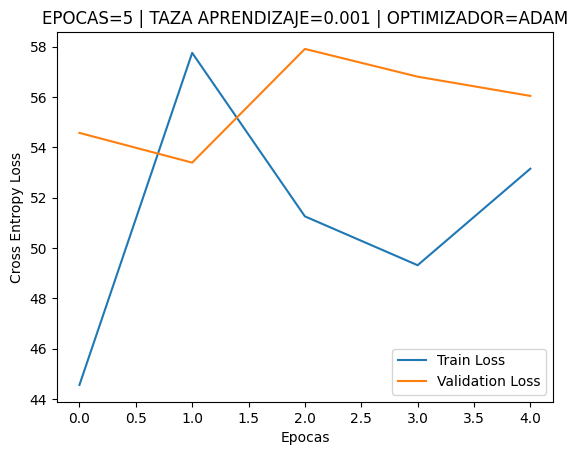

In [153]:
model = Net(n_qubits = 3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=10, LEARNING RATE=0.001, OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11972\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 31.6219
Epoch [1/10]	Validation	Loss: 15.3776	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 16.3126
Epoch [2/10]	Validation	Loss: 12.8650	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 5.7337
Epoch [3/10]	Validation	Loss: 2.4498	Validation Accuracy: 51.5%
Epoch [4/10]	Training [40%]	Loss: 1.1572
Epoch [4/10]	Validation	Loss: 4.3339	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 1.3102
Epoch [5/10]	Validation	Loss: 1.7032	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.8231
Epoch [6/10]	Validation	Loss: 0.7037	Validation Accuracy: 57.5%
Epoch [7/10]	Training [70%]	Loss: 0.7352
Epoch [7/10]	Validation	Loss: 0.6998	Validation Accuracy: 59.0%
Epoch [8/10]	Training [80%]	Loss: 0.6699
Epoch [8/10]	Validation	Loss: 2.2028	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.8373
Epoch [9/10]	Validation	Loss: 0.8221	Validation Accuracy: 60.0%
Epoch [10/10]	Training [100%]	Loss: 0.6504
Epoch [1

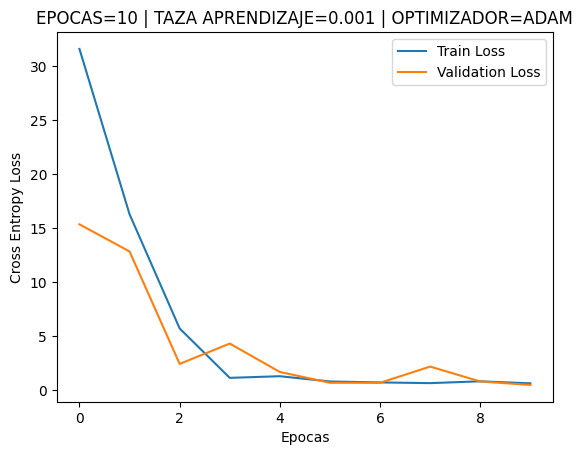

In [154]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 20.6963
Epoch [1/15]	Validation	Loss: 13.3225	Validation Accuracy: 52.5%
Epoch [2/15]	Training [13%]	Loss: 17.9141
Epoch [2/15]	Validation	Loss: 10.9322	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 11.0753
Epoch [3/15]	Validation	Loss: 1.8834	Validation Accuracy: 31.5%
Epoch [4/15]	Training [27%]	Loss: 4.6486
Epoch [4/15]	Validation	Loss: 3.3260	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 1.0783
Epoch [5/15]	Validation	Loss: 0.6962	Validation Accuracy: 53.0%
Epoch [6/15]	Training [40%]	Loss: 0.8517
Epoch [6/15]	Validation	Loss: 0.9213	Validation Accuracy: 49.5%
Epoch [7/15]	Training [47%]	Loss: 0.8634
Epoch [7/15]	Validation	Loss: 0.7617	Validation Accuracy: 55.5%
Epoch [8/15]	Training [53%]	Loss: 0.7949
Epoch [8/15]	Validation	Loss: 0.7856	Validation Accuracy: 64.5%
Epoch [9/15]	Training [60%]	Loss: 0.7754
Epoch [9/15]	Validation	Loss: 0.6305	Validation Accuracy: 65.5%
Epoch [10/15]	Training [67%]	Loss: 0.7691
Epoch [10

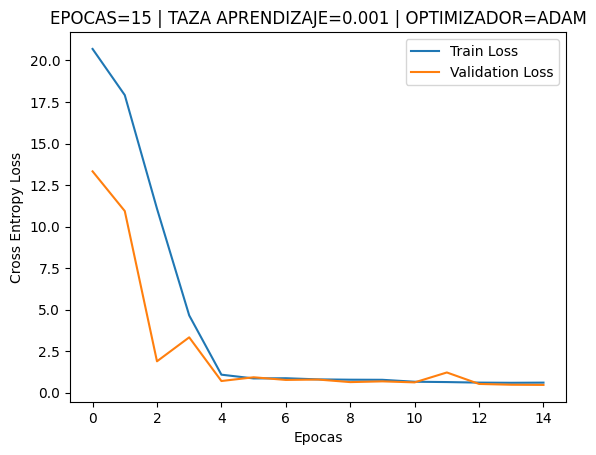

In [19]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 29.0660
Epoch [1/20]	Validation	Loss: 9.3728	Validation Accuracy: 52.0%
Epoch [2/20]	Training [10%]	Loss: 15.8380
Epoch [2/20]	Validation	Loss: 1.1461	Validation Accuracy: 58.0%
Epoch [3/20]	Training [15%]	Loss: 5.1061
Epoch [3/20]	Validation	Loss: 0.7598	Validation Accuracy: 52.0%
Epoch [4/20]	Training [20%]	Loss: 1.1614
Epoch [4/20]	Validation	Loss: 0.7169	Validation Accuracy: 48.5%
Epoch [5/20]	Training [25%]	Loss: 0.8484
Epoch [5/20]	Validation	Loss: 0.6753	Validation Accuracy: 55.5%
Epoch [6/20]	Training [30%]	Loss: 0.8090
Epoch [6/20]	Validation	Loss: 0.8529	Validation Accuracy: 52.5%
Epoch [7/20]	Training [35%]	Loss: 0.7302
Epoch [7/20]	Validation	Loss: 0.6899	Validation Accuracy: 52.5%
Epoch [8/20]	Training [40%]	Loss: 0.7557
Epoch [8/20]	Validation	Loss: 0.6580	Validation Accuracy: 61.5%
Epoch [9/20]	Training [45%]	Loss: 0.8497
Epoch [9/20]	Validation	Loss: 0.7387	Validation Accuracy: 54.5%
Epoch [10/20]	Training [50%]	Loss: 0.7740
Epoch [10/20

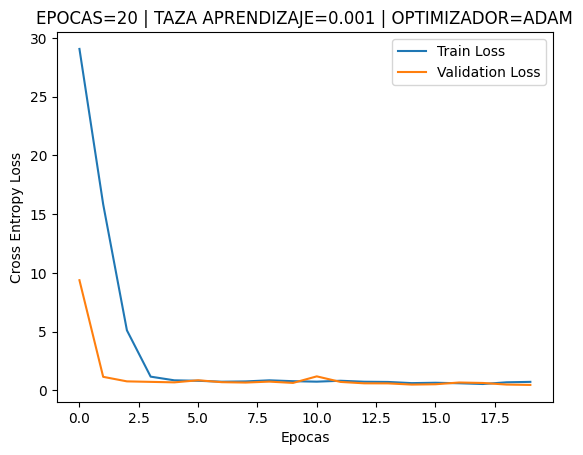

In [20]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=30 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/30]	Training [3%]	Loss: 34.3998
Epoch [1/30]	Validation	Loss: 10.3231	Validation Accuracy: 50.0%
Epoch [2/30]	Training [7%]	Loss: 18.1394
Epoch [2/30]	Validation	Loss: 13.1288	Validation Accuracy: 50.0%
Epoch [3/30]	Training [10%]	Loss: 14.3595
Epoch [3/30]	Validation	Loss: 10.3540	Validation Accuracy: 50.0%
Epoch [4/30]	Training [13%]	Loss: 12.5750
Epoch [4/30]	Validation	Loss: 9.6822	Validation Accuracy: 50.0%
Epoch [5/30]	Training [17%]	Loss: 10.2231
Epoch [5/30]	Validation	Loss: 9.7955	Validation Accuracy: 50.0%
Epoch [6/30]	Training [20%]	Loss: 9.6067
Epoch [6/30]	Validation	Loss: 9.6376	Validation Accuracy: 50.0%
Epoch [7/30]	Training [23%]	Loss: 9.5516
Epoch [7/30]	Validation	Loss: 10.0634	Validation Accuracy: 50.0%
Epoch [8/30]	Training [27%]	Loss: 9.5411
Epoch [8/30]	Validation	Loss: 9.5391	Validation Accuracy: 50.0%
Epoch [9/30]	Training [30%]	Loss: 9.5374
Epoch [9/30]	Validation	Loss: 9.5537	Validation Accuracy: 50.0%
Epoch [10/30]	Training [33%]	Loss: 9.5545
Epoch 

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


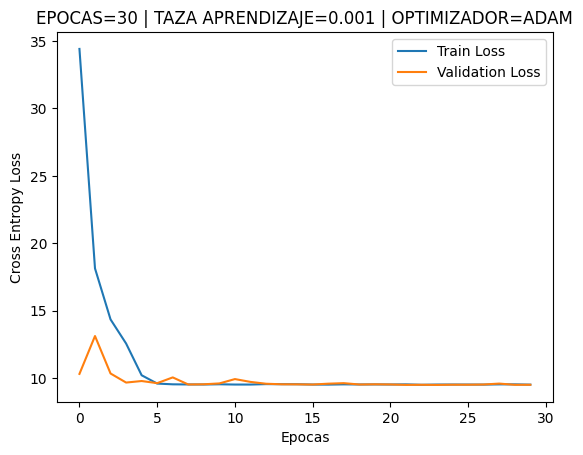

In [21]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 30
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=30 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 *******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 46.7157
Epoch [1/5]	Validation	Loss: 31.3855	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 28.1528
Epoch [2/5]	Validation	Loss: 65.6727	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 23.6054
Epoch [3/5]	Validation	Loss: 58.3436	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 27.6141
Epoch [4/5]	Validation	Loss: 54.8206	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 31.5589
Epoch [5/5]	Validation	Loss: 56.1321	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 56.1321
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


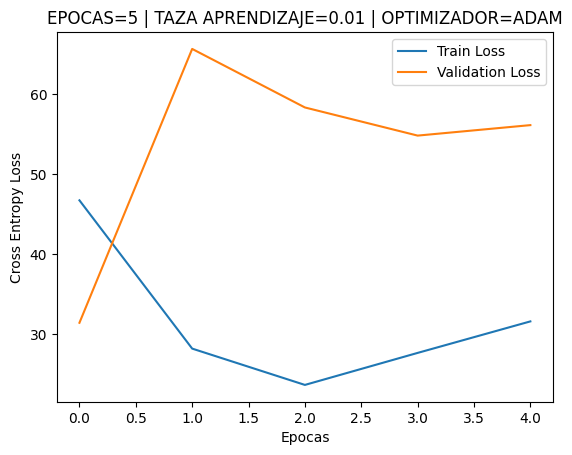

In [22]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 32.9420
Epoch [1/10]	Validation	Loss: 35.3104	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 6.0407
Epoch [2/10]	Validation	Loss: 33.2485	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 5.2741
Epoch [3/10]	Validation	Loss: 30.1553	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 13.2980
Epoch [4/10]	Validation	Loss: 26.7232	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 5.6900
Epoch [5/10]	Validation	Loss: 26.8495	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 5.4175
Epoch [6/10]	Validation	Loss: 30.2073	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 7.0446
Epoch [7/10]	Validation	Loss: 22.4757	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 10.0291
Epoch [8/10]	Validation	Loss: 31.3064	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 5.6040
Epoch [9/10]	Validation	Loss: 30.1600	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 6.1307


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


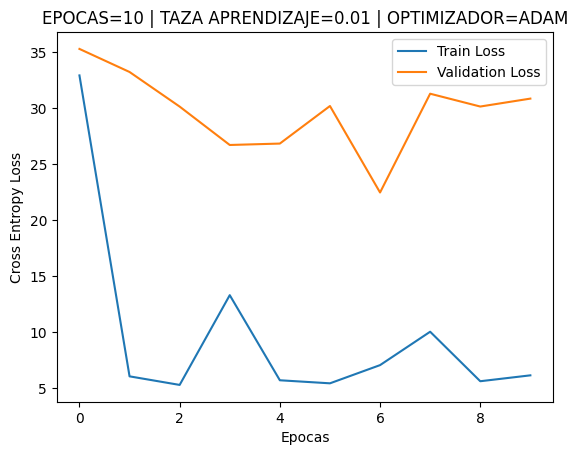

In [23]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 25.4389
Epoch [1/15]	Validation	Loss: 9.5580	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 9.5226
Epoch [2/15]	Validation	Loss: 9.5000	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 9.5381
Epoch [3/15]	Validation	Loss: 9.5036	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 9.5337
Epoch [4/15]	Validation	Loss: 9.5153	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 9.5414
Epoch [5/15]	Validation	Loss: 9.5066	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 9.5631
Epoch [6/15]	Validation	Loss: 9.6624	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 9.5784
Epoch [7/15]	Validation	Loss: 9.6474	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 9.5970
Epoch [8/15]	Validation	Loss: 9.5781	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 9.5906
Epoch [9/15]	Validation	Loss: 9.5691	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 9.6110
Epoch [10/15]

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


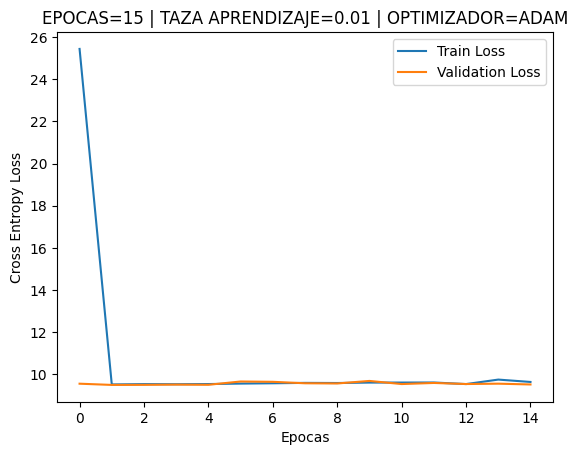

In [24]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 12.1816
Epoch [1/20]	Validation	Loss: 0.8003	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.9064
Epoch [2/20]	Validation	Loss: 1.4917	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.8291
Epoch [3/20]	Validation	Loss: 0.7804	Validation Accuracy: 48.5%
Epoch [4/20]	Training [20%]	Loss: 0.9906
Epoch [4/20]	Validation	Loss: 0.7243	Validation Accuracy: 50.5%
Epoch [5/20]	Training [25%]	Loss: 1.0606
Epoch [5/20]	Validation	Loss: 1.7640	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.9712
Epoch [6/20]	Validation	Loss: 0.8318	Validation Accuracy: 51.5%
Epoch [7/20]	Training [35%]	Loss: 1.0609
Epoch [7/20]	Validation	Loss: 0.7366	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.9694
Epoch [8/20]	Validation	Loss: 0.9385	Validation Accuracy: 47.5%
Epoch [9/20]	Training [45%]	Loss: 1.0115
Epoch [9/20]	Validation	Loss: 1.0811	Validation Accuracy: 49.0%
Epoch [10/20]	Training [50%]	Loss: 0.9222
Epoch [10/20]

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


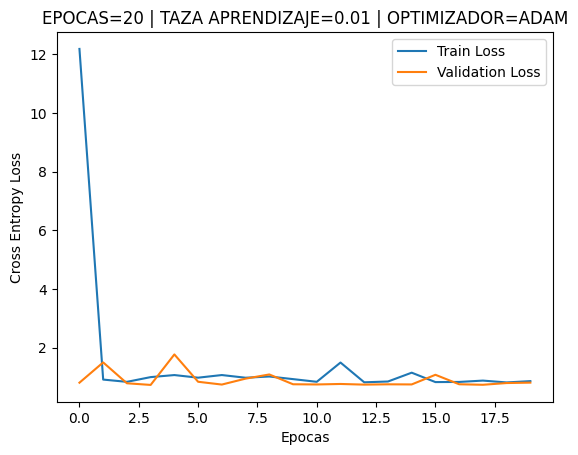

In [25]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 39.2505
Epoch [1/5]	Validation	Loss: 8.7336	Validation Accuracy: 55.5%
Epoch [2/5]	Training [40%]	Loss: 18.5489
Epoch [2/5]	Validation	Loss: 5.7500	Validation Accuracy: 56.0%
Epoch [3/5]	Training [60%]	Loss: 9.9609
Epoch [3/5]	Validation	Loss: 4.8507	Validation Accuracy: 54.0%
Epoch [4/5]	Training [80%]	Loss: 11.5366
Epoch [4/5]	Validation	Loss: 3.7301	Validation Accuracy: 53.0%
Epoch [5/5]	Training [100%]	Loss: 11.3385
Epoch [5/5]	Validation	Loss: 2.4229	Validation Accuracy: 61.0%
Performance on the test data:
	Loss: 2.4229
	Accuracy: 61.0%
	precision: 70.5%
	recall: 61.0%
	f_score: 55.9%
(0.7046130952380952, 0.61, 0.5590230664857531, None)

Confusion Matrix:
[[95  5]
 [73 27]]


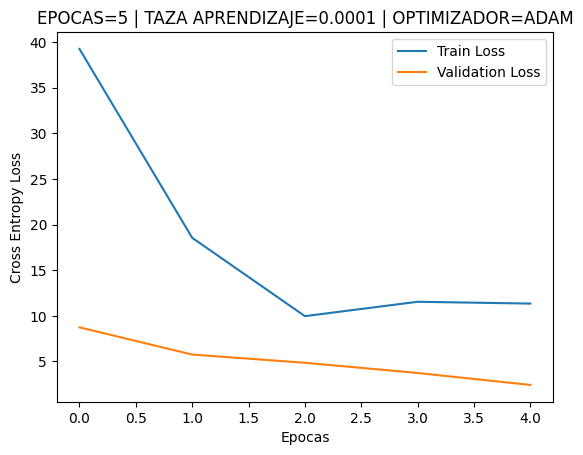

In [26]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 31.7219
Epoch [1/10]	Validation	Loss: 9.0432	Validation Accuracy: 57.0%
Epoch [2/10]	Training [20%]	Loss: 17.6595
Epoch [2/10]	Validation	Loss: 14.1287	Validation Accuracy: 52.5%
Epoch [3/10]	Training [30%]	Loss: 14.6577
Epoch [3/10]	Validation	Loss: 8.1274	Validation Accuracy: 55.5%
Epoch [4/10]	Training [40%]	Loss: 13.8942
Epoch [4/10]	Validation	Loss: 17.7802	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 11.8353
Epoch [5/10]	Validation	Loss: 6.3108	Validation Accuracy: 55.5%
Epoch [6/10]	Training [60%]	Loss: 7.7220
Epoch [6/10]	Validation	Loss: 11.9382	Validation Accuracy: 51.0%
Epoch [7/10]	Training [70%]	Loss: 10.4688
Epoch [7/10]	Validation	Loss: 4.8630	Validation Accuracy: 58.0%
Epoch [8/10]	Training [80%]	Loss: 7.6772
Epoch [8/10]	Validation	Loss: 14.4456	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 8.3654
Epoch [9/10]	Validation	Loss: 2.2762	Validation Accuracy: 55.0%
Epoch [10/10]	Training [100%]	Loss: 6.6633
Ep

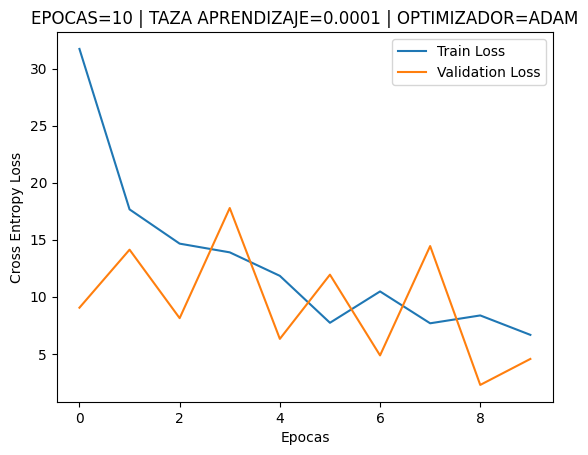

In [27]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 36.7511
Epoch [1/15]	Validation	Loss: 7.3574	Validation Accuracy: 57.0%
Epoch [2/15]	Training [13%]	Loss: 17.1596
Epoch [2/15]	Validation	Loss: 7.4950	Validation Accuracy: 57.5%
Epoch [3/15]	Training [20%]	Loss: 12.4067
Epoch [3/15]	Validation	Loss: 4.5331	Validation Accuracy: 57.5%
Epoch [4/15]	Training [27%]	Loss: 13.3870
Epoch [4/15]	Validation	Loss: 4.9401	Validation Accuracy: 59.0%
Epoch [5/15]	Training [33%]	Loss: 9.5529
Epoch [5/15]	Validation	Loss: 2.8306	Validation Accuracy: 55.5%
Epoch [6/15]	Training [40%]	Loss: 9.8207
Epoch [6/15]	Validation	Loss: 10.2250	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 8.7021
Epoch [7/15]	Validation	Loss: 18.3404	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 6.0629
Epoch [8/15]	Validation	Loss: 14.6169	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 6.4364
Epoch [9/15]	Validation	Loss: 11.4923	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 5.8593
Epoch 

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


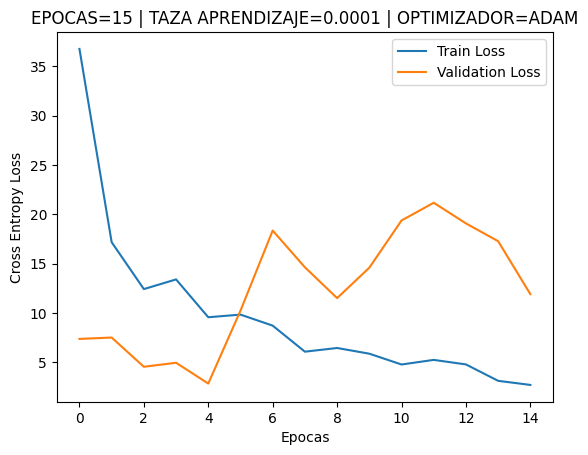

In [28]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 29.9761
Epoch [1/20]	Validation	Loss: 12.7792	Validation Accuracy: 54.5%
Epoch [2/20]	Training [10%]	Loss: 17.7413
Epoch [2/20]	Validation	Loss: 9.1371	Validation Accuracy: 57.0%
Epoch [3/20]	Training [15%]	Loss: 13.2230
Epoch [3/20]	Validation	Loss: 6.8784	Validation Accuracy: 57.0%
Epoch [4/20]	Training [20%]	Loss: 11.8886
Epoch [4/20]	Validation	Loss: 4.2577	Validation Accuracy: 61.5%
Epoch [5/20]	Training [25%]	Loss: 13.4546
Epoch [5/20]	Validation	Loss: 4.1855	Validation Accuracy: 59.0%
Epoch [6/20]	Training [30%]	Loss: 10.4844
Epoch [6/20]	Validation	Loss: 1.9818	Validation Accuracy: 56.0%
Epoch [7/20]	Training [35%]	Loss: 10.0106
Epoch [7/20]	Validation	Loss: 2.2273	Validation Accuracy: 62.0%
Epoch [8/20]	Training [40%]	Loss: 7.6950
Epoch [8/20]	Validation	Loss: 1.0464	Validation Accuracy: 59.5%
Epoch [9/20]	Training [45%]	Loss: 10.8556
Epoch [9/20]	Validation	Loss: 6.0006	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 6.9775
Epoch

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


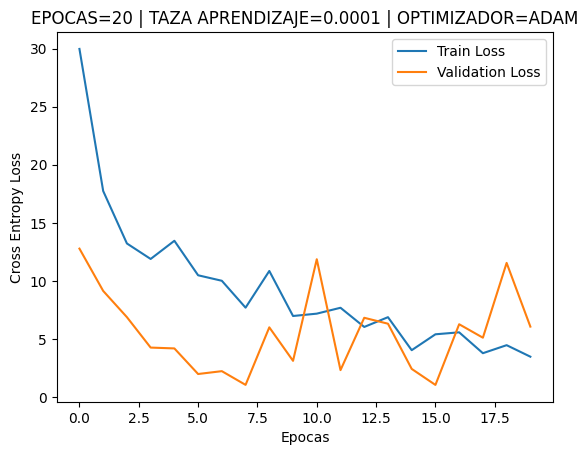

In [29]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

--------------------------------------SGD-----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\2542014694.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 42.3753
Epoch [1/5]	Validation	Loss: 0.7893	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.7822
Epoch [2/5]	Validation	Loss: 1.2703	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.7996
Epoch [3/5]	Validation	Loss: 0.7393	Validation Accuracy: 49.5%
Epoch [4/5]	Training [80%]	Loss: 0.7380
Epoch [4/5]	Validation	Loss: 0.6764	Validation Accuracy: 56.5%
Epoch [5/5]	Training [100%]	Loss: 0.7744
Epoch [5/5]	Validation	Loss: 0.7684	Validation Accuracy: 51.0%
Performance on the test data:
	Loss: 0.7684
	Accuracy: 51.0%
	precision: 75.3%
	recall: 51.0%
	f_score: 35.5%
(0.7525252525252526, 0.51, 0.3551783129359126, None)

Confusion Matrix:
[[  2  98]
 [  0 100]]


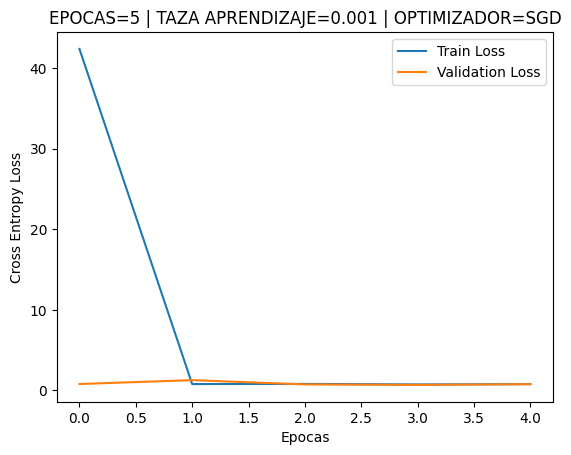

In [30]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 51.8480
Epoch [1/10]	Validation	Loss: 100.8921	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 29.4568
Epoch [2/10]	Validation	Loss: 0.7498	Validation Accuracy: 48.5%
Epoch [3/10]	Training [30%]	Loss: 0.7572
Epoch [3/10]	Validation	Loss: 0.7423	Validation Accuracy: 46.0%
Epoch [4/10]	Training [40%]	Loss: 0.7403
Epoch [4/10]	Validation	Loss: 0.7013	Validation Accuracy: 51.0%
Epoch [5/10]	Training [50%]	Loss: 0.7361
Epoch [5/10]	Validation	Loss: 0.7387	Validation Accuracy: 50.5%
Epoch [6/10]	Training [60%]	Loss: 0.7895
Epoch [6/10]	Validation	Loss: 0.7201	Validation Accuracy: 51.0%
Epoch [7/10]	Training [70%]	Loss: 0.7477
Epoch [7/10]	Validation	Loss: 0.7386	Validation Accuracy: 50.5%
Epoch [8/10]	Training [80%]	Loss: 0.7611
Epoch [8/10]	Validation	Loss: 0.6990	Validation Accuracy: 56.0%
Epoch [9/10]	Training [90%]	Loss: 0.7639
Epoch [9/10]	Validation	Loss: 0.7012	Validation Accuracy: 51.0%
Epoch [10/10]	Training [100%]	Loss: 0.7987
Epoch [1

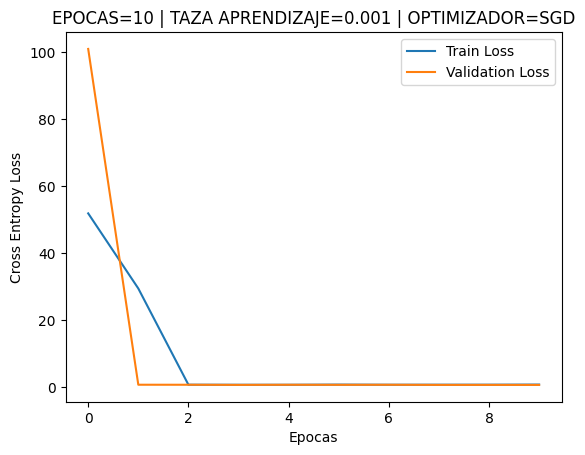

In [38]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 38.4591
Epoch [1/15]	Validation	Loss: 0.7390	Validation Accuracy: 52.0%
Epoch [2/15]	Training [13%]	Loss: 0.7961
Epoch [2/15]	Validation	Loss: 0.7423	Validation Accuracy: 44.5%
Epoch [3/15]	Training [20%]	Loss: 0.7764
Epoch [3/15]	Validation	Loss: 0.7260	Validation Accuracy: 47.5%
Epoch [4/15]	Training [27%]	Loss: 0.8072
Epoch [4/15]	Validation	Loss: 0.7054	Validation Accuracy: 54.5%
Epoch [5/15]	Training [33%]	Loss: 0.7752
Epoch [5/15]	Validation	Loss: 0.7609	Validation Accuracy: 49.5%
Epoch [6/15]	Training [40%]	Loss: 0.7931
Epoch [6/15]	Validation	Loss: 0.7604	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 0.7349
Epoch [7/15]	Validation	Loss: 0.7731	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.7999
Epoch [8/15]	Validation	Loss: 0.7172	Validation Accuracy: 52.0%
Epoch [9/15]	Training [60%]	Loss: 0.8230
Epoch [9/15]	Validation	Loss: 0.7756	Validation Accuracy: 48.0%
Epoch [10/15]	Training [67%]	Loss: 0.7745
Epoch [10/15]

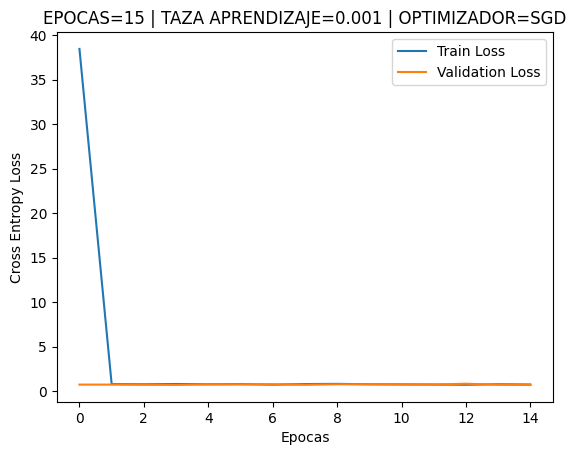

In [42]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 51.0225
Epoch [1/20]	Validation	Loss: 2.1708	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.8382
Epoch [2/20]	Validation	Loss: 0.8180	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.8276
Epoch [3/20]	Validation	Loss: 0.8191	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.8282
Epoch [4/20]	Validation	Loss: 0.8760	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 0.8217
Epoch [5/20]	Validation	Loss: 0.8234	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.8227
Epoch [6/20]	Validation	Loss: 0.8214	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 0.8160
Epoch [7/20]	Validation	Loss: 0.8227	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.8227
Epoch [8/20]	Validation	Loss: 0.8155	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 0.8250
Epoch [9/20]	Validation	Loss: 0.8250	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 0.8195
Epoch [10/20]

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


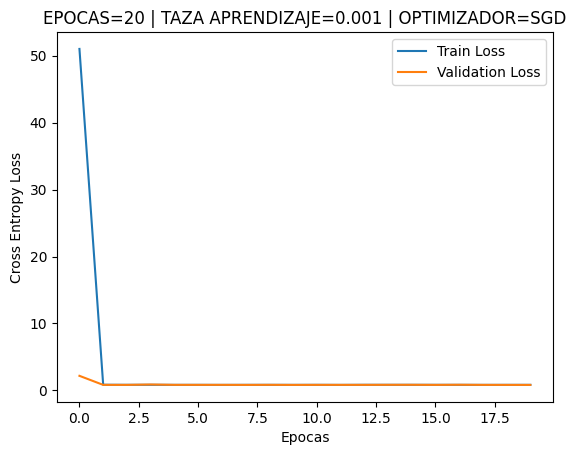

In [43]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\512218691.py:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 19.0112
Epoch [1/5]	Validation	Loss: 9.5432	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 10.8175
Epoch [2/5]	Validation	Loss: 10.4703	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 9.9280
Epoch [3/5]	Validation	Loss: 10.5875	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 10.1443
Epoch [4/5]	Validation	Loss: 9.8395	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 10.3967
Epoch [5/5]	Validation	Loss: 9.7828	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 9.7828
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


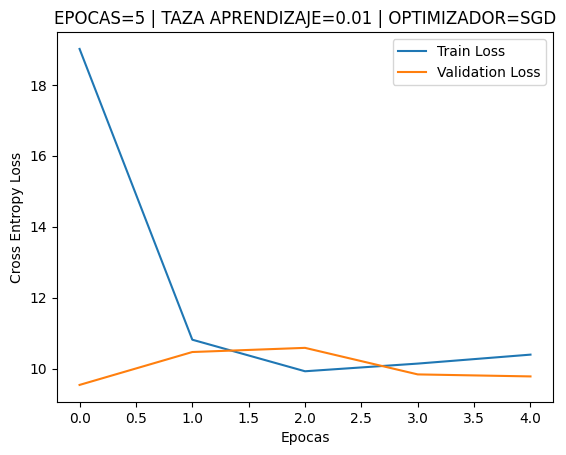

In [51]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 18.7093
Epoch [1/10]	Validation	Loss: 9.9908	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 10.2167
Epoch [2/10]	Validation	Loss: 10.0654	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 10.6649
Epoch [3/10]	Validation	Loss: 11.8448	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 10.4520
Epoch [4/10]	Validation	Loss: 9.7505	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 10.6904
Epoch [5/10]	Validation	Loss: 10.5744	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 11.0257
Epoch [6/10]	Validation	Loss: 12.7492	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 11.2137
Epoch [7/10]	Validation	Loss: 10.0120	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 10.2035
Epoch [8/10]	Validation	Loss: 9.8345	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 10.6265
Epoch [9/10]	Validation	Loss: 10.5965	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 9.99

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


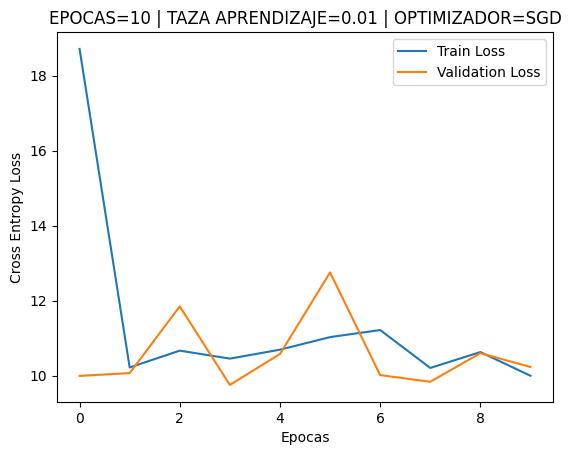

In [79]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\3505079330.py:43: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 54.9591
Epoch [1/15]	Validation	Loss: 54.9792	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 54.9967
Epoch [2/15]	Validation	Loss: 54.9167	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 54.8946
Epoch [3/15]	Validation	Loss: 55.1703	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 55.3099
Epoch [4/15]	Validation	Loss: 54.8614	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 55.1859
Epoch [5/15]	Validation	Loss: 54.8985	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 54.9128
Epoch [6/15]	Validation	Loss: 54.9909	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 54.8350
Epoch [7/15]	Validation	Loss: 54.9111	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 54.9895
Epoch [8/15]	Validation	Loss: 55.1254	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 55.0462
Epoch [9/15]	Validation	Loss: 54.8743	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 55.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


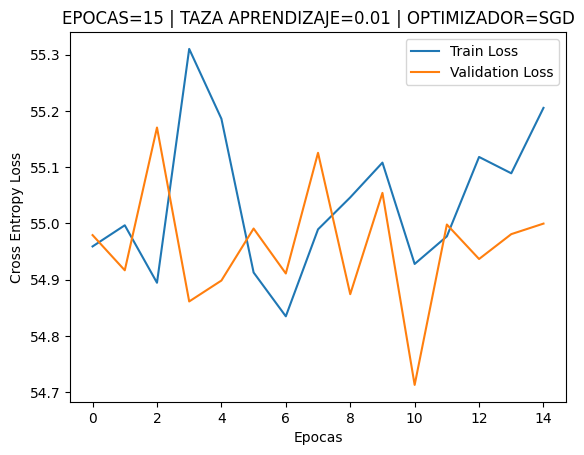

In [89]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 23.8277
Epoch [1/20]	Validation	Loss: 10.3238	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 11.1807
Epoch [2/20]	Validation	Loss: 11.6369	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 10.6229
Epoch [3/20]	Validation	Loss: 9.8119	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 10.5904
Epoch [4/20]	Validation	Loss: 11.1234	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 10.5622
Epoch [5/20]	Validation	Loss: 10.0039	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 10.4596
Epoch [6/20]	Validation	Loss: 10.1083	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 10.0594
Epoch [7/20]	Validation	Loss: 11.9687	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 10.5809
Epoch [8/20]	Validation	Loss: 10.7165	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 10.4748
Epoch [9/20]	Validation	Loss: 9.6685	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 10.74

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


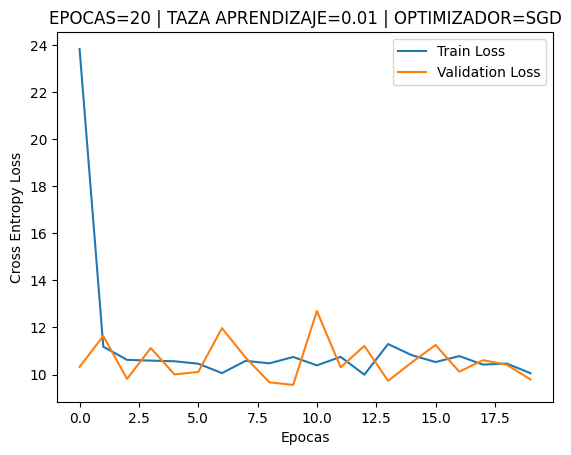

In [93]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 54.9812
Epoch [1/5]	Validation	Loss: 55.0537	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 54.6691
Epoch [2/5]	Validation	Loss: 55.0045	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 55.1150
Epoch [3/5]	Validation	Loss: 55.0137	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 54.6005
Epoch [4/5]	Validation	Loss: 55.3099	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 54.8844
Epoch [5/5]	Validation	Loss: 55.0014	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 55.0014
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


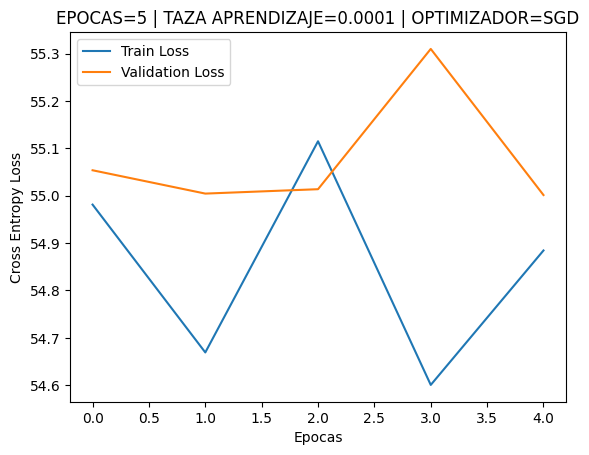

In [94]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)


C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 54.8119
Epoch [1/10]	Validation	Loss: 54.8284	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 55.2789
Epoch [2/10]	Validation	Loss: 54.9346	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 54.9033
Epoch [3/10]	Validation	Loss: 55.1232	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 49.4614
Epoch [4/10]	Validation	Loss: 6.7005	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 22.5205
Epoch [5/10]	Validation	Loss: 42.0851	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 7.9882
Epoch [6/10]	Validation	Loss: 7.4436	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 3.3982
Epoch [7/10]	Validation	Loss: 2.2292	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 2.0105
Epoch [8/10]	Validation	Loss: 1.2790	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 1.2857
Epoch [9/10]	Validation	Loss: 3.9855	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 1.1752
Epo

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


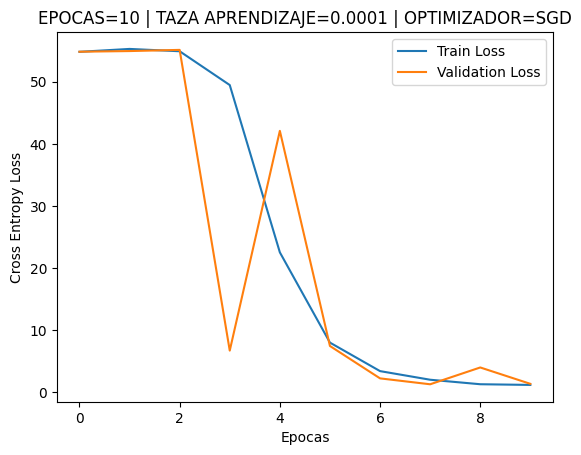

In [95]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 55.0180
Epoch [1/15]	Validation	Loss: 54.9962	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 52.2765
Epoch [2/15]	Validation	Loss: 54.7004	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 54.9350
Epoch [3/15]	Validation	Loss: 54.8096	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 54.6450
Epoch [4/15]	Validation	Loss: 54.3930	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 53.5237
Epoch [5/15]	Validation	Loss: 50.9131	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 31.7628
Epoch [6/15]	Validation	Loss: 0.7278	Validation Accuracy: 47.0%
Epoch [7/15]	Training [47%]	Loss: 1.6771
Epoch [7/15]	Validation	Loss: 0.7880	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.8640
Epoch [8/15]	Validation	Loss: 0.7280	Validation Accuracy: 49.5%
Epoch [9/15]	Training [60%]	Loss: 0.7794
Epoch [9/15]	Validation	Loss: 0.7356	Validation Accuracy: 47.0%
Epoch [10/15]	Training [67%]	Loss: 0.7775
Epo

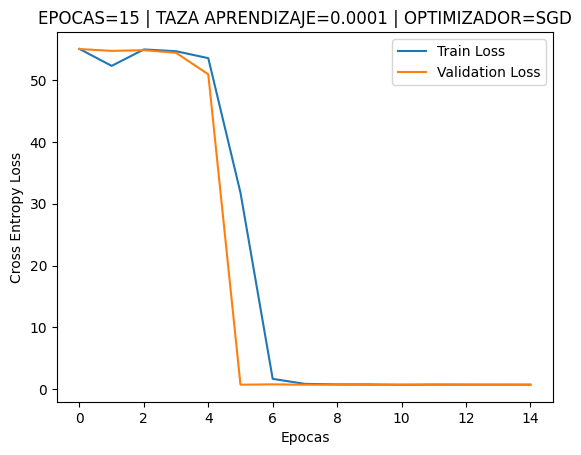

In [96]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 54.9126
Epoch [1/20]	Validation	Loss: 54.9480	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 55.0439
Epoch [2/20]	Validation	Loss: 55.0480	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 55.1226
Epoch [3/20]	Validation	Loss: 54.5720	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 52.0876
Epoch [4/20]	Validation	Loss: 26.4562	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 27.7886
Epoch [5/20]	Validation	Loss: 2.8834	Validation Accuracy: 60.5%
Epoch [6/20]	Training [30%]	Loss: 8.7257
Epoch [6/20]	Validation	Loss: 0.7398	Validation Accuracy: 56.0%
Epoch [7/20]	Training [35%]	Loss: 1.9477
Epoch [7/20]	Validation	Loss: 0.7650	Validation Accuracy: 44.5%
Epoch [8/20]	Training [40%]	Loss: 1.4645
Epoch [8/20]	Validation	Loss: 0.8226	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 1.0311
Epoch [9/20]	Validation	Loss: 0.7281	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 0.8065
Epoch

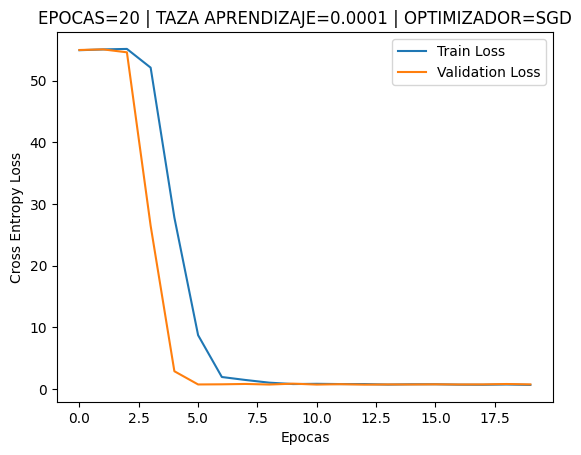

In [98]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adadelta--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 55.0948
Epoch [1/5]	Validation	Loss: 55.1419	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 54.8872
Epoch [2/5]	Validation	Loss: 55.0734	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 55.1069
Epoch [3/5]	Validation	Loss: 55.2174	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 55.0395
Epoch [4/5]	Validation	Loss: 54.9737	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 54.8389
Epoch [5/5]	Validation	Loss: 54.9412	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 54.9412
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


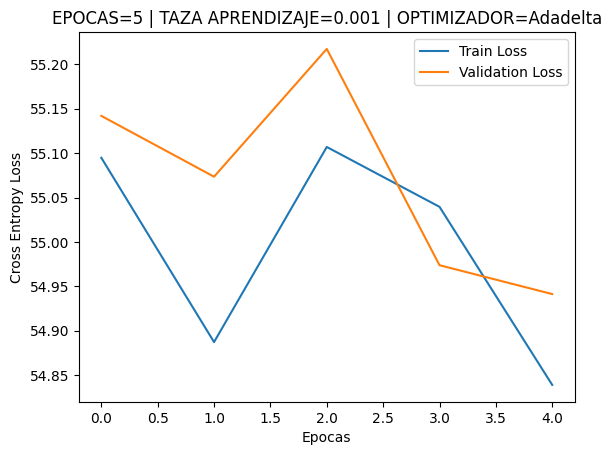

In [99]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\764306115.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 55.1754
Epoch [1/10]	Validation	Loss: 55.0946	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 55.0336
Epoch [2/10]	Validation	Loss: 55.0374	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 54.7859
Epoch [3/10]	Validation	Loss: 55.2569	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 54.7835
Epoch [4/10]	Validation	Loss: 54.6036	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 55.0694
Epoch [5/10]	Validation	Loss: 55.0393	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 54.9843
Epoch [6/10]	Validation	Loss: 55.1523	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 54.8181
Epoch [7/10]	Validation	Loss: 55.1535	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 54.8534
Epoch [8/10]	Validation	Loss: 54.7521	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 54.9301
Epoch [9/10]	Validation	Loss: 55.1883	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 5

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


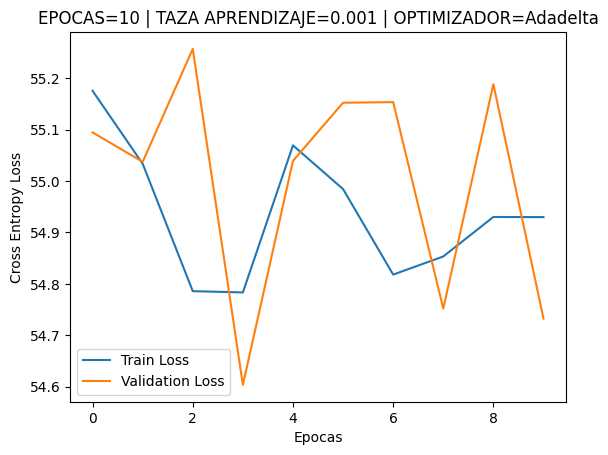

In [100]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 54.7599
Epoch [1/15]	Validation	Loss: 55.0406	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 55.1525
Epoch [2/15]	Validation	Loss: 54.7661	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 55.2628
Epoch [3/15]	Validation	Loss: 54.9981	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 55.0408
Epoch [4/15]	Validation	Loss: 54.8349	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 55.0496
Epoch [5/15]	Validation	Loss: 55.1834	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 54.8761
Epoch [6/15]	Validation	Loss: 55.1384	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 54.7014
Epoch [7/15]	Validation	Loss: 54.8744	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 55.1711
Epoch [8/15]	Validation	Loss: 54.8783	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 54.9024
Epoch [9/15]	Validation	Loss: 55.0725	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 55.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


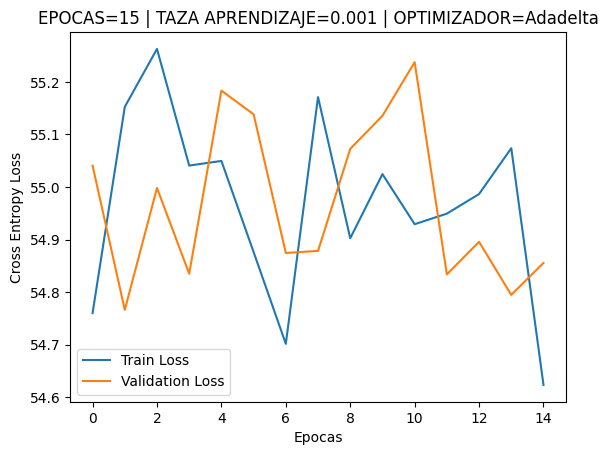

In [106]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 55.2351
Epoch [1/20]	Validation	Loss: 55.1828	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 55.0347
Epoch [2/20]	Validation	Loss: 54.8840	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 54.7711
Epoch [3/20]	Validation	Loss: 54.9057	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 55.1758
Epoch [4/20]	Validation	Loss: 55.0771	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 54.9918
Epoch [5/20]	Validation	Loss: 55.0985	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 54.8205
Epoch [6/20]	Validation	Loss: 54.7852	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 54.6571
Epoch [7/20]	Validation	Loss: 54.9897	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 55.0025
Epoch [8/20]	Validation	Loss: 54.8070	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 55.2211
Epoch [9/20]	Validation	Loss: 54.7343	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 55.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


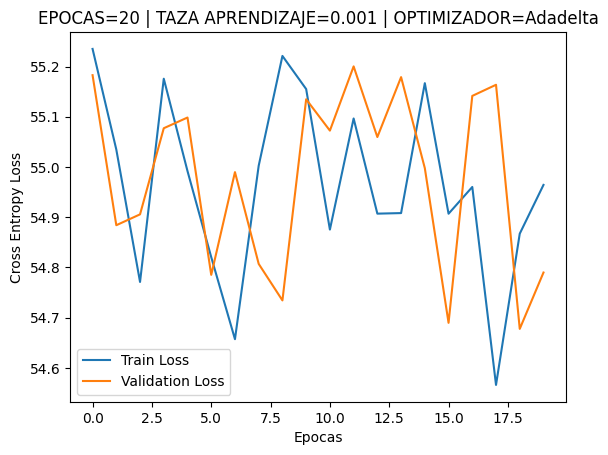

In [107]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ********************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 54.9448
Epoch [1/5]	Validation	Loss: 55.0509	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 54.7797
Epoch [2/5]	Validation	Loss: 55.1948	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 54.9233
Epoch [3/5]	Validation	Loss: 54.9221	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 54.1257
Epoch [4/5]	Validation	Loss: 52.9240	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 46.7380
Epoch [5/5]	Validation	Loss: 34.7438	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 34.7438
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


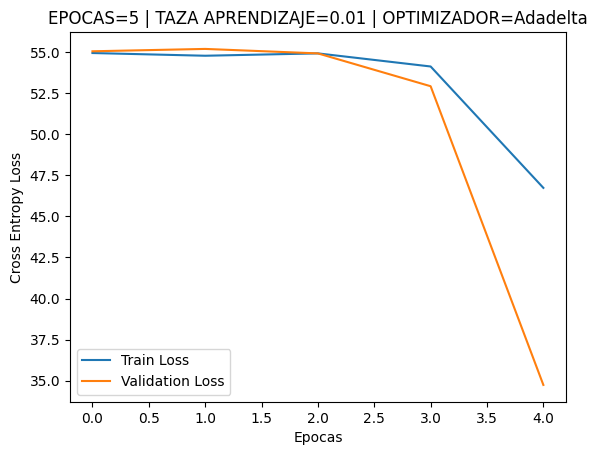

In [108]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 54.8698
Epoch [1/10]	Validation	Loss: 55.0284	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 54.6602
Epoch [2/10]	Validation	Loss: 54.9427	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 55.0423
Epoch [3/10]	Validation	Loss: 54.6559	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 53.8726
Epoch [4/10]	Validation	Loss: 51.9651	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 44.0672
Epoch [5/10]	Validation	Loss: 29.2317	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 24.1357
Epoch [6/10]	Validation	Loss: 11.4054	Validation Accuracy: 54.0%
Epoch [7/10]	Training [70%]	Loss: 15.1716
Epoch [7/10]	Validation	Loss: 11.0127	Validation Accuracy: 56.5%
Epoch [8/10]	Training [80%]	Loss: 16.7859
Epoch [8/10]	Validation	Loss: 11.3905	Validation Accuracy: 55.5%
Epoch [9/10]	Training [90%]	Loss: 17.0617
Epoch [9/10]	Validation	Loss: 11.0307	Validation Accuracy: 56.5%
Epoch [10/10]	Training [100%]	Loss: 1

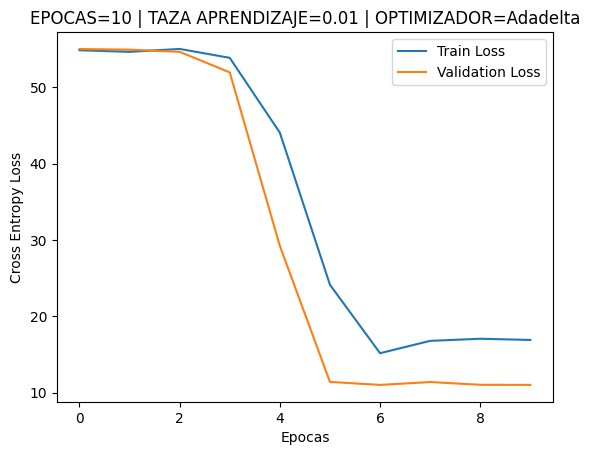

In [109]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 55.1045
Epoch [1/15]	Validation	Loss: 54.9059	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 54.9648
Epoch [2/15]	Validation	Loss: 54.7856	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 54.2697
Epoch [3/15]	Validation	Loss: 53.0642	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 48.8452
Epoch [4/15]	Validation	Loss: 38.8470	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 28.3954
Epoch [5/15]	Validation	Loss: 10.6019	Validation Accuracy: 53.5%
Epoch [6/15]	Training [40%]	Loss: 16.5224
Epoch [6/15]	Validation	Loss: 9.5112	Validation Accuracy: 55.5%
Epoch [7/15]	Training [47%]	Loss: 17.8756
Epoch [7/15]	Validation	Loss: 9.1948	Validation Accuracy: 57.5%
Epoch [8/15]	Training [53%]	Loss: 15.6626
Epoch [8/15]	Validation	Loss: 9.2472	Validation Accuracy: 56.5%
Epoch [9/15]	Training [60%]	Loss: 17.3087
Epoch [9/15]	Validation	Loss: 8.9954	Validation Accuracy: 56.5%
Epoch [10/15]	Training [67%]	Loss: 14.1892

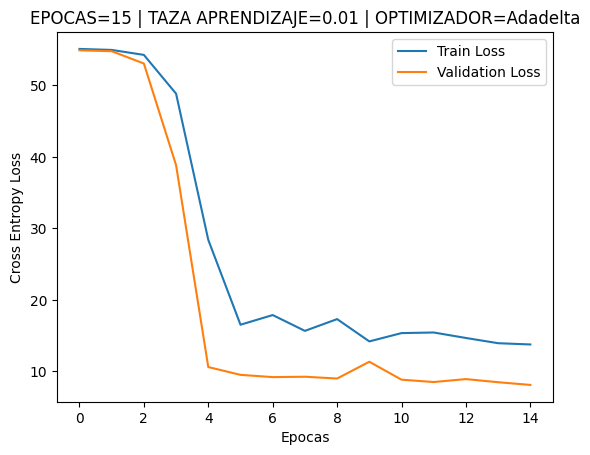

In [110]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 54.8277
Epoch [1/20]	Validation	Loss: 54.9618	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 55.0184
Epoch [2/20]	Validation	Loss: 54.4802	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 52.7857
Epoch [3/20]	Validation	Loss: 49.3136	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 33.1920
Epoch [4/20]	Validation	Loss: 12.0800	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 15.2017
Epoch [5/20]	Validation	Loss: 7.6721	Validation Accuracy: 59.5%
Epoch [6/20]	Training [30%]	Loss: 13.4924
Epoch [6/20]	Validation	Loss: 7.1853	Validation Accuracy: 56.5%
Epoch [7/20]	Training [35%]	Loss: 12.8705
Epoch [7/20]	Validation	Loss: 6.9860	Validation Accuracy: 57.0%
Epoch [8/20]	Training [40%]	Loss: 16.9793
Epoch [8/20]	Validation	Loss: 7.3191	Validation Accuracy: 56.5%
Epoch [9/20]	Training [45%]	Loss: 15.1017
Epoch [9/20]	Validation	Loss: 7.3153	Validation Accuracy: 58.5%
Epoch [10/20]	Training [50%]	Loss: 12.1468


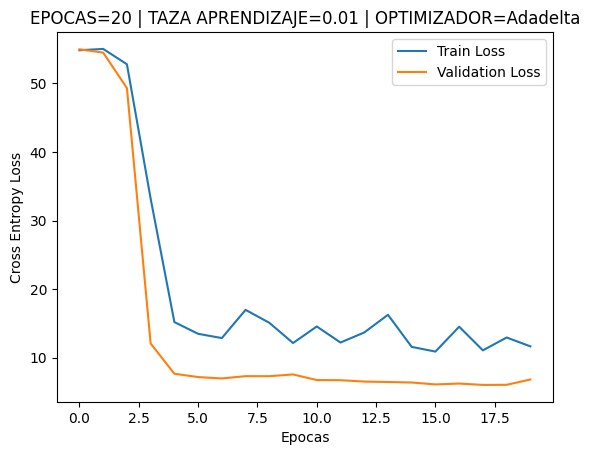

In [111]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 54.9005
Epoch [1/5]	Validation	Loss: 54.8297	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 55.1784
Epoch [2/5]	Validation	Loss: 55.1230	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 54.8251
Epoch [3/5]	Validation	Loss: 54.6395	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 54.7850
Epoch [4/5]	Validation	Loss: 55.0052	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 55.0241
Epoch [5/5]	Validation	Loss: 54.8985	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 54.8985
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


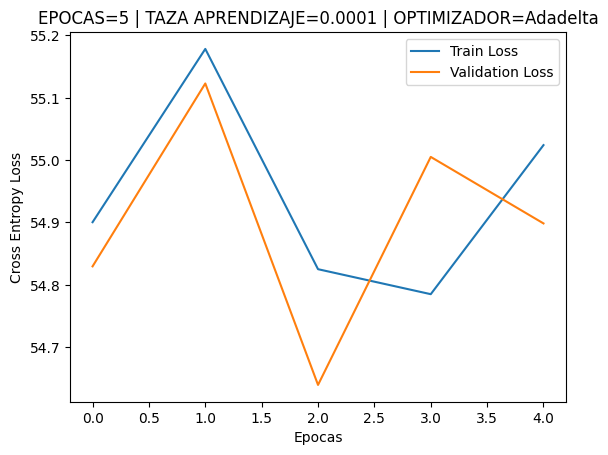

In [112]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 54.7148
Epoch [1/10]	Validation	Loss: 55.2018	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 55.1045
Epoch [2/10]	Validation	Loss: 55.0618	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 55.0810
Epoch [3/10]	Validation	Loss: 54.9047	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 55.1794
Epoch [4/10]	Validation	Loss: 54.7645	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 55.0130
Epoch [5/10]	Validation	Loss: 55.1027	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 55.0131
Epoch [6/10]	Validation	Loss: 55.1362	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 54.9827
Epoch [7/10]	Validation	Loss: 55.2917	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 55.2691
Epoch [8/10]	Validation	Loss: 54.9214	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 55.0060
Epoch [9/10]	Validation	Loss: 55.0657	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 5

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


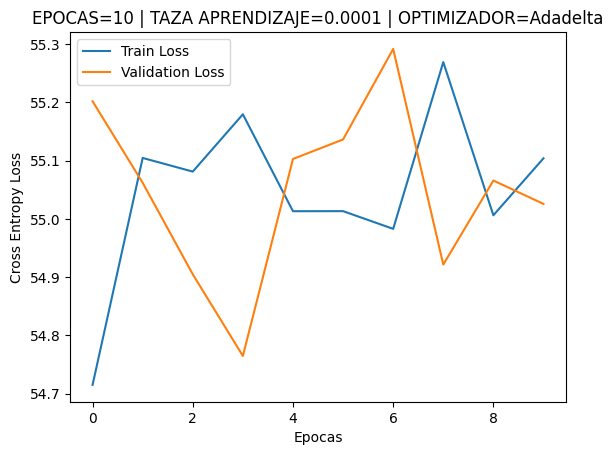

In [113]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 54.8947
Epoch [1/15]	Validation	Loss: 54.8507	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 54.6795
Epoch [2/15]	Validation	Loss: 55.1715	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 55.2117
Epoch [3/15]	Validation	Loss: 55.1613	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 54.7231
Epoch [4/15]	Validation	Loss: 55.0427	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 55.2519
Epoch [5/15]	Validation	Loss: 54.7636	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 54.8844
Epoch [6/15]	Validation	Loss: 54.8702	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 55.3558
Epoch [7/15]	Validation	Loss: 54.9085	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 54.7415
Epoch [8/15]	Validation	Loss: 54.9616	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 55.0597
Epoch [9/15]	Validation	Loss: 55.0322	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 54.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


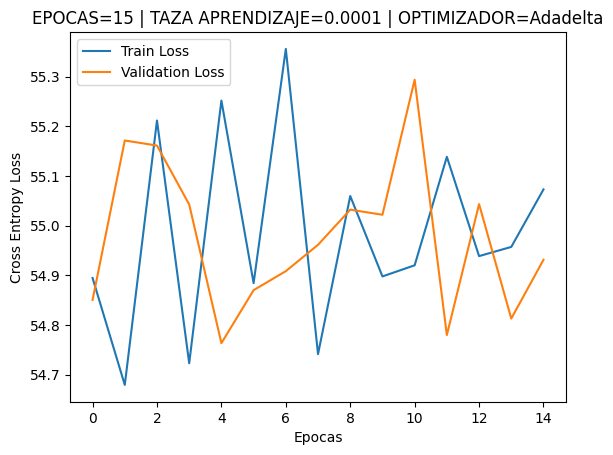

In [114]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 54.9603
Epoch [1/20]	Validation	Loss: 55.1253	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 54.9917
Epoch [2/20]	Validation	Loss: 55.0348	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 55.0681
Epoch [3/20]	Validation	Loss: 55.0888	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 55.2928
Epoch [4/20]	Validation	Loss: 54.9935	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 54.9498
Epoch [5/20]	Validation	Loss: 54.6812	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 54.9917
Epoch [6/20]	Validation	Loss: 55.0762	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 54.9871
Epoch [7/20]	Validation	Loss: 55.1770	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 54.8344
Epoch [8/20]	Validation	Loss: 55.0374	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 54.9595
Epoch [9/20]	Validation	Loss: 54.8568	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 55.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


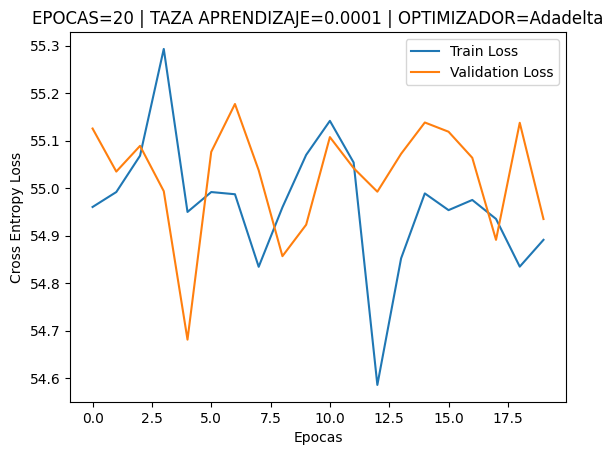

In [115]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adagrad--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 23.0883
Epoch [1/5]	Validation	Loss: 7.8563	Validation Accuracy: 58.5%
Epoch [2/5]	Training [40%]	Loss: 14.2247
Epoch [2/5]	Validation	Loss: 6.4366	Validation Accuracy: 57.0%
Epoch [3/5]	Training [60%]	Loss: 13.5977
Epoch [3/5]	Validation	Loss: 5.8412	Validation Accuracy: 58.0%
Epoch [4/5]	Training [80%]	Loss: 13.6225
Epoch [4/5]	Validation	Loss: 6.0648	Validation Accuracy: 57.0%
Epoch [5/5]	Training [100%]	Loss: 10.5668
Epoch [5/5]	Validation	Loss: 10.5056	Validation Accuracy: 55.5%
Performance on the test data:
	Loss: 10.5056
	Accuracy: 55.5%
	precision: 76.5%
	recall: 55.5%
	f_score: 44.5%
(0.7645502645502645, 0.555, 0.4451198603447738, None)

Confusion Matrix:
[[100   0]
 [ 89  11]]


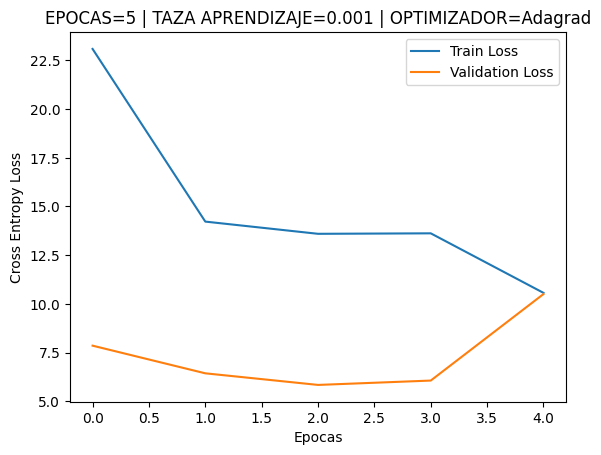

In [116]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 31.4546
Epoch [1/10]	Validation	Loss: 12.5958	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 16.7821
Epoch [2/10]	Validation	Loss: 9.1866	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 13.4005
Epoch [3/10]	Validation	Loss: 9.1022	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 16.2847
Epoch [4/10]	Validation	Loss: 8.8088	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 15.3588
Epoch [5/10]	Validation	Loss: 7.6821	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 11.2842
Epoch [6/10]	Validation	Loss: 8.3321	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 11.4900
Epoch [7/10]	Validation	Loss: 9.8927	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 9.4635
Epoch [8/10]	Validation	Loss: 8.7175	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 11.3289
Epoch [9/10]	Validation	Loss: 14.2492	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 12.2082
E

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


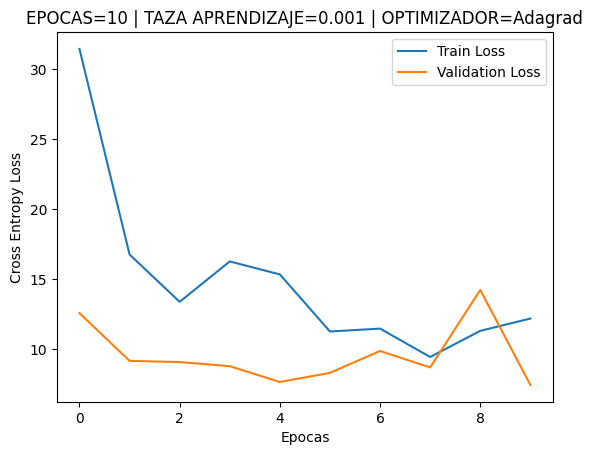

In [117]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 19.0347
Epoch [1/15]	Validation	Loss: 8.0147	Validation Accuracy: 55.5%
Epoch [2/15]	Training [13%]	Loss: 14.7318
Epoch [2/15]	Validation	Loss: 7.0331	Validation Accuracy: 56.5%
Epoch [3/15]	Training [20%]	Loss: 13.8211
Epoch [3/15]	Validation	Loss: 6.6453	Validation Accuracy: 56.5%
Epoch [4/15]	Training [27%]	Loss: 10.7072
Epoch [4/15]	Validation	Loss: 7.0256	Validation Accuracy: 56.0%
Epoch [5/15]	Training [33%]	Loss: 10.9007
Epoch [5/15]	Validation	Loss: 5.2209	Validation Accuracy: 57.0%
Epoch [6/15]	Training [40%]	Loss: 10.4238
Epoch [6/15]	Validation	Loss: 5.1056	Validation Accuracy: 58.0%
Epoch [7/15]	Training [47%]	Loss: 10.2490
Epoch [7/15]	Validation	Loss: 4.4093	Validation Accuracy: 57.5%
Epoch [8/15]	Training [53%]	Loss: 9.1834
Epoch [8/15]	Validation	Loss: 6.0470	Validation Accuracy: 58.5%
Epoch [9/15]	Training [60%]	Loss: 9.4338
Epoch [9/15]	Validation	Loss: 4.6838	Validation Accuracy: 59.5%
Epoch [10/15]	Training [67%]	Loss: 9.7352
Epoch [

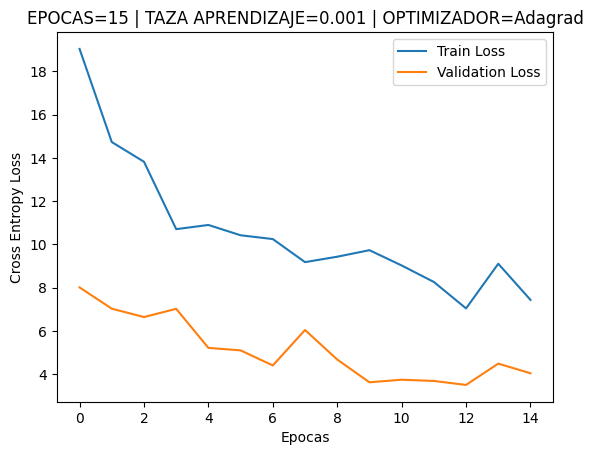

In [118]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 23.9718
Epoch [1/20]	Validation	Loss: 9.7129	Validation Accuracy: 55.5%
Epoch [2/20]	Training [10%]	Loss: 13.8402
Epoch [2/20]	Validation	Loss: 8.2746	Validation Accuracy: 56.5%
Epoch [3/20]	Training [15%]	Loss: 12.1585
Epoch [3/20]	Validation	Loss: 9.5393	Validation Accuracy: 54.0%
Epoch [4/20]	Training [20%]	Loss: 13.9591
Epoch [4/20]	Validation	Loss: 5.6691	Validation Accuracy: 56.5%
Epoch [5/20]	Training [25%]	Loss: 12.3673
Epoch [5/20]	Validation	Loss: 4.9758	Validation Accuracy: 57.5%
Epoch [6/20]	Training [30%]	Loss: 11.6286
Epoch [6/20]	Validation	Loss: 5.2488	Validation Accuracy: 56.5%
Epoch [7/20]	Training [35%]	Loss: 11.1113
Epoch [7/20]	Validation	Loss: 6.1062	Validation Accuracy: 56.5%
Epoch [8/20]	Training [40%]	Loss: 9.1920
Epoch [8/20]	Validation	Loss: 4.0474	Validation Accuracy: 57.5%
Epoch [9/20]	Training [45%]	Loss: 8.9183
Epoch [9/20]	Validation	Loss: 5.0349	Validation Accuracy: 60.5%
Epoch [10/20]	Training [50%]	Loss: 8.0990
Epoch [

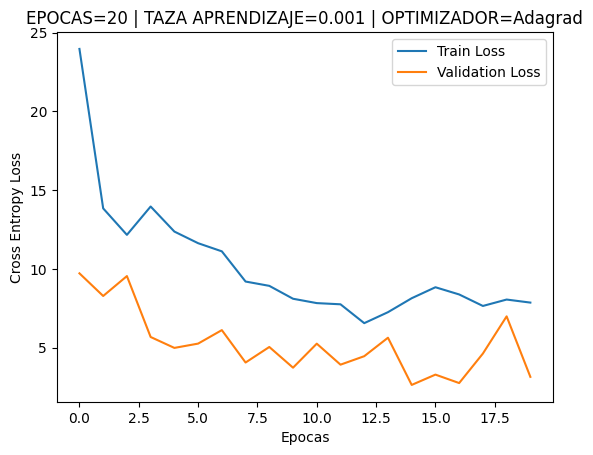

In [119]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 26.2358
Epoch [1/5]	Validation	Loss: 16.0902	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 11.7449
Epoch [2/5]	Validation	Loss: 11.8205	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 5.5818
Epoch [3/5]	Validation	Loss: 9.9084	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 2.2939
Epoch [4/5]	Validation	Loss: 12.4049	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 1.2291
Epoch [5/5]	Validation	Loss: 8.6110	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 8.6110
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


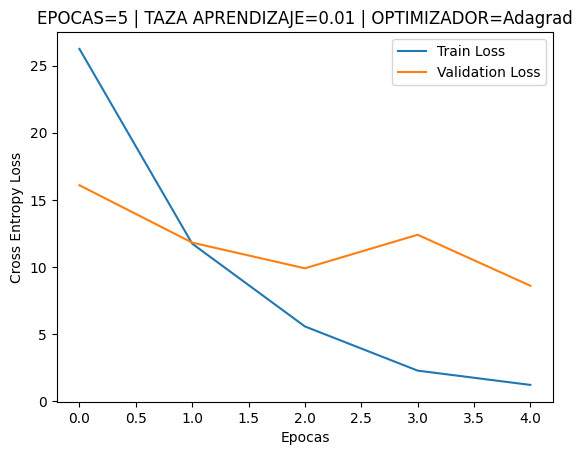

In [120]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 56.3778
Epoch [1/10]	Validation	Loss: 55.6818	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 55.7642
Epoch [2/10]	Validation	Loss: 55.9527	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 53.2920
Epoch [3/10]	Validation	Loss: 60.7442	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 54.2183
Epoch [4/10]	Validation	Loss: 55.7017	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 58.1736
Epoch [5/10]	Validation	Loss: 53.9125	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 54.9339
Epoch [6/10]	Validation	Loss: 57.9567	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 58.5897
Epoch [7/10]	Validation	Loss: 43.8512	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 52.2439
Epoch [8/10]	Validation	Loss: 42.7570	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 51.9920
Epoch [9/10]	Validation	Loss: 44.7977	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 5

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


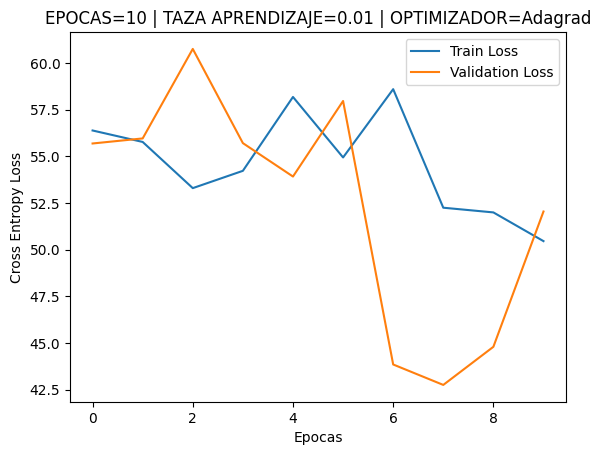

In [121]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 30.8490
Epoch [1/15]	Validation	Loss: 4.2945	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 14.1274
Epoch [2/15]	Validation	Loss: 3.4585	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 6.6229
Epoch [3/15]	Validation	Loss: 6.3316	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 4.1113
Epoch [4/15]	Validation	Loss: 5.9550	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 2.6643
Epoch [5/15]	Validation	Loss: 5.9883	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 1.7379
Epoch [6/15]	Validation	Loss: 7.8906	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 1.2540
Epoch [7/15]	Validation	Loss: 7.0919	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 1.1400
Epoch [8/15]	Validation	Loss: 9.1039	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 1.0103
Epoch [9/15]	Validation	Loss: 7.3983	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.8877
Epoch [10/15

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


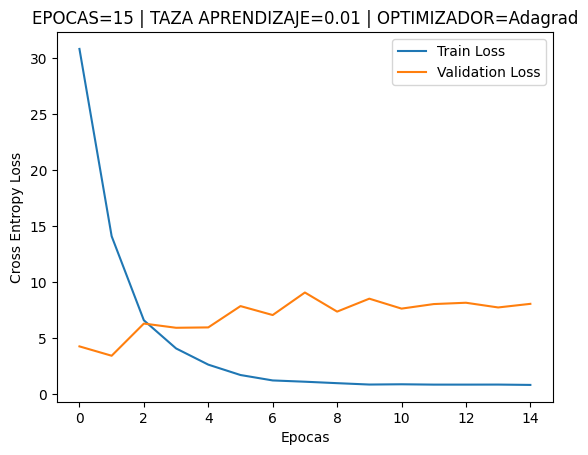

In [122]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 53.0971
Epoch [1/20]	Validation	Loss: 55.4354	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 54.3745
Epoch [2/20]	Validation	Loss: 57.8924	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 55.3864
Epoch [3/20]	Validation	Loss: 53.1976	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 57.1530
Epoch [4/20]	Validation	Loss: 56.2831	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 54.1574
Epoch [5/20]	Validation	Loss: 54.6432	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 56.1825
Epoch [6/20]	Validation	Loss: 54.8687	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 52.9045
Epoch [7/20]	Validation	Loss: 52.2727	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 55.5745
Epoch [8/20]	Validation	Loss: 57.1951	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 56.0993
Epoch [9/20]	Validation	Loss: 54.6457	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 56.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


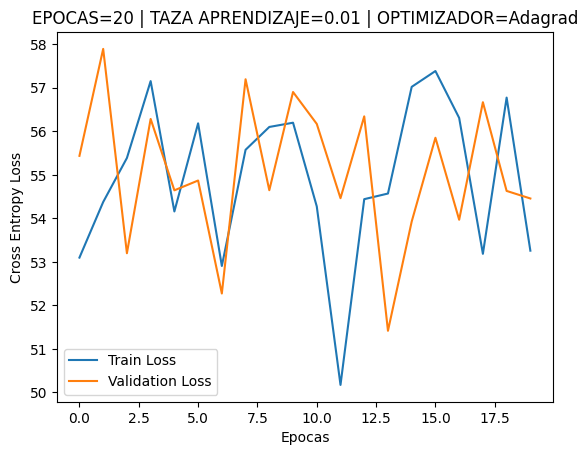

In [123]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 54.4662
Epoch [1/5]	Validation	Loss: 52.9566	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 44.7750
Epoch [2/5]	Validation	Loss: 30.9950	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 21.3098
Epoch [3/5]	Validation	Loss: 9.3014	Validation Accuracy: 56.0%
Epoch [4/5]	Training [80%]	Loss: 14.4225
Epoch [4/5]	Validation	Loss: 7.2294	Validation Accuracy: 55.5%
Epoch [5/5]	Training [100%]	Loss: 14.3528
Epoch [5/5]	Validation	Loss: 7.3083	Validation Accuracy: 58.0%
Performance on the test data:
	Loss: 7.3083
	Accuracy: 58.0%
	precision: 77.2%
	recall: 58.0%
	f_score: 49.0%
(0.7717391304347826, 0.58, 0.4900437105390967, None)

Confusion Matrix:
[[100   0]
 [ 84  16]]


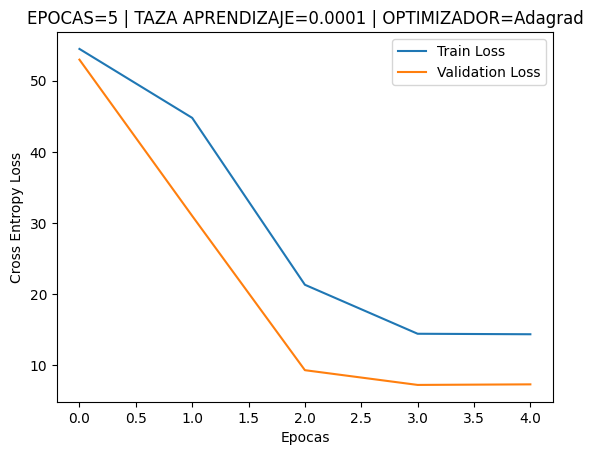

In [124]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 54.8173
Epoch [1/10]	Validation	Loss: 54.7343	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 54.8417
Epoch [2/10]	Validation	Loss: 54.8822	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 54.9970
Epoch [3/10]	Validation	Loss: 54.7836	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 54.8270
Epoch [4/10]	Validation	Loss: 54.9929	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 54.2350
Epoch [5/10]	Validation	Loss: 53.9843	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 51.7910
Epoch [6/10]	Validation	Loss: 49.4976	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 45.1840
Epoch [7/10]	Validation	Loss: 37.7594	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 28.7859
Epoch [8/10]	Validation	Loss: 20.6095	Validation Accuracy: 50.5%
Epoch [9/10]	Training [90%]	Loss: 22.6482
Epoch [9/10]	Validation	Loss: 13.8838	Validation Accuracy: 54.5%
Epoch [10/10]	Training [100%]	Loss: 1

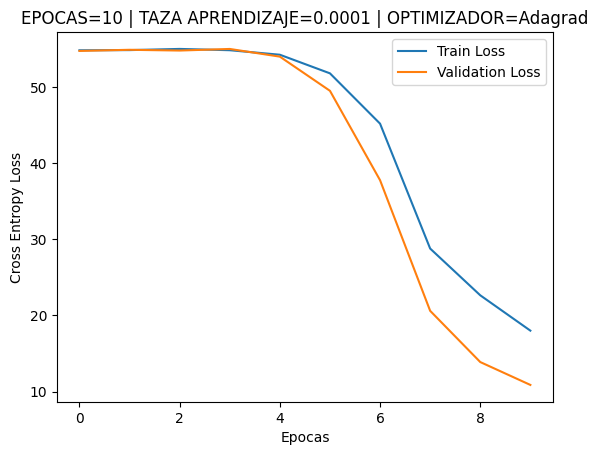

In [125]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 55.0660
Epoch [1/15]	Validation	Loss: 54.5271	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 52.8360
Epoch [2/15]	Validation	Loss: 50.1241	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 39.9130
Epoch [3/15]	Validation	Loss: 28.7173	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 23.4627
Epoch [4/15]	Validation	Loss: 13.1059	Validation Accuracy: 53.0%
Epoch [5/15]	Training [33%]	Loss: 19.0190
Epoch [5/15]	Validation	Loss: 10.0518	Validation Accuracy: 55.0%
Epoch [6/15]	Training [40%]	Loss: 18.4102
Epoch [6/15]	Validation	Loss: 8.9497	Validation Accuracy: 55.5%
Epoch [7/15]	Training [47%]	Loss: 18.8060
Epoch [7/15]	Validation	Loss: 7.8648	Validation Accuracy: 56.5%
Epoch [8/15]	Training [53%]	Loss: 12.9824
Epoch [8/15]	Validation	Loss: 7.6527	Validation Accuracy: 55.0%
Epoch [9/15]	Training [60%]	Loss: 18.9517
Epoch [9/15]	Validation	Loss: 7.6353	Validation Accuracy: 56.0%
Epoch [10/15]	Training [67%]	Loss: 14.4886

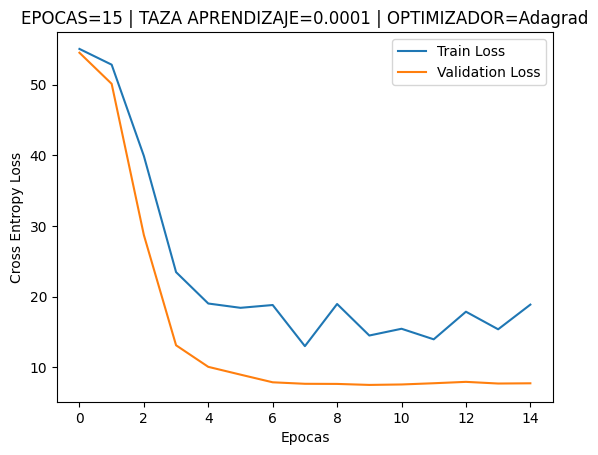

In [126]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 54.9119
Epoch [1/20]	Validation	Loss: 55.0722	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 55.1374
Epoch [2/20]	Validation	Loss: 54.9794	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 54.9740
Epoch [3/20]	Validation	Loss: 54.9235	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 54.6858
Epoch [4/20]	Validation	Loss: 54.4504	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 53.0738
Epoch [5/20]	Validation	Loss: 51.5927	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 46.3636
Epoch [6/20]	Validation	Loss: 38.0529	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 30.3516
Epoch [7/20]	Validation	Loss: 19.6546	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 18.7818
Epoch [8/20]	Validation	Loss: 11.7064	Validation Accuracy: 54.5%
Epoch [9/20]	Training [45%]	Loss: 20.0471
Epoch [9/20]	Validation	Loss: 10.0404	Validation Accuracy: 56.0%
Epoch [10/20]	Training [50%]	Loss: 14.

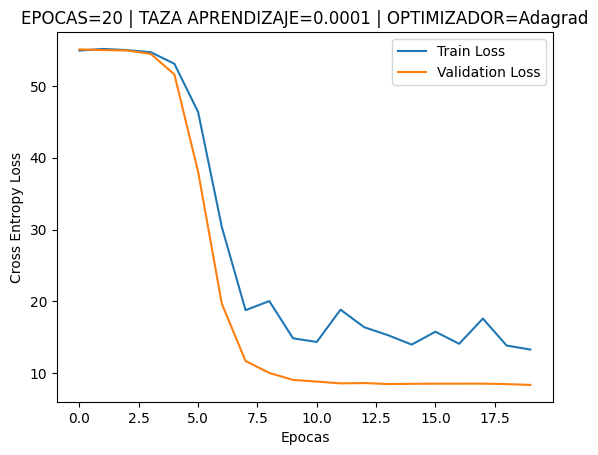

In [127]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------RMSprop--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 26.0522
Epoch [1/5]	Validation	Loss: 17.3015	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 14.8487
Epoch [2/5]	Validation	Loss: 13.9241	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 12.3492
Epoch [3/5]	Validation	Loss: 10.4830	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 10.1804
Epoch [4/5]	Validation	Loss: 10.1584	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 9.8887
Epoch [5/5]	Validation	Loss: 10.6220	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 10.6220
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


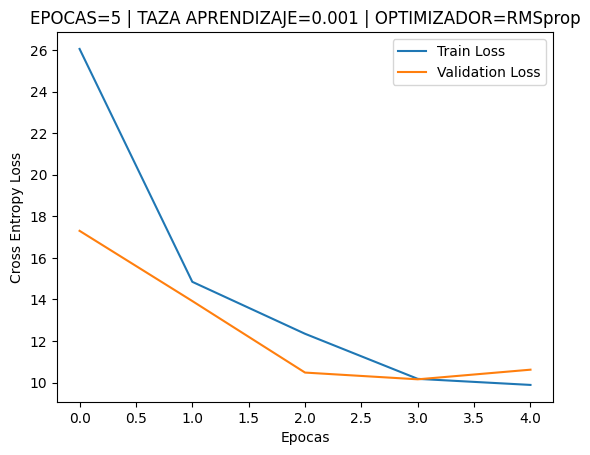

In [128]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 48.2226
Epoch [1/10]	Validation	Loss: 58.2462	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 45.0332
Epoch [2/10]	Validation	Loss: 48.5217	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 52.2940
Epoch [3/10]	Validation	Loss: 55.2017	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 53.4597
Epoch [4/10]	Validation	Loss: 54.5536	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 52.7259
Epoch [5/10]	Validation	Loss: 53.0824	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 53.2619
Epoch [6/10]	Validation	Loss: 57.5010	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 52.7511
Epoch [7/10]	Validation	Loss: 52.1943	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 50.5810
Epoch [8/10]	Validation	Loss: 50.5601	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 50.5732
Epoch [9/10]	Validation	Loss: 56.9910	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 5

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


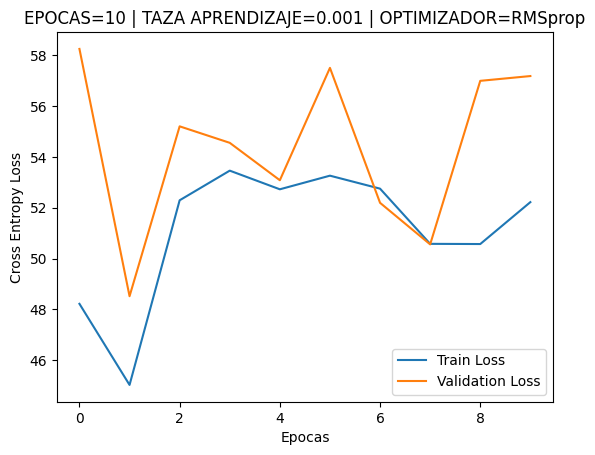

In [129]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 56.2284
Epoch [1/15]	Validation	Loss: 57.6471	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 55.8601
Epoch [2/15]	Validation	Loss: 56.4989	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 59.1678
Epoch [3/15]	Validation	Loss: 55.9330	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 52.2773
Epoch [4/15]	Validation	Loss: 56.6729	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 54.1723
Epoch [5/15]	Validation	Loss: 46.8580	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 56.3429
Epoch [6/15]	Validation	Loss: 53.6393	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 57.4059
Epoch [7/15]	Validation	Loss: 53.4683	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 53.1103
Epoch [8/15]	Validation	Loss: 54.1055	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 57.7985
Epoch [9/15]	Validation	Loss: 51.8310	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 56.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


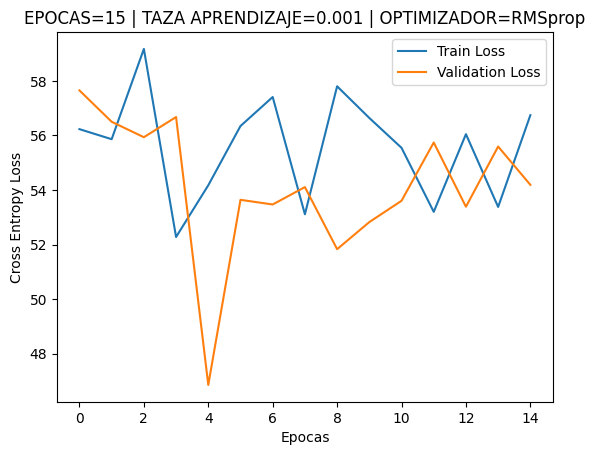

In [130]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 28.5376
Epoch [1/20]	Validation	Loss: 3.9479	Validation Accuracy: 56.0%
Epoch [2/20]	Training [10%]	Loss: 6.8732
Epoch [2/20]	Validation	Loss: 0.9923	Validation Accuracy: 51.5%
Epoch [3/20]	Training [15%]	Loss: 1.4862
Epoch [3/20]	Validation	Loss: 3.1858	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 1.0128
Epoch [4/20]	Validation	Loss: 0.6800	Validation Accuracy: 63.0%
Epoch [5/20]	Training [25%]	Loss: 0.9409
Epoch [5/20]	Validation	Loss: 0.7981	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.8841
Epoch [6/20]	Validation	Loss: 0.7464	Validation Accuracy: 48.0%
Epoch [7/20]	Training [35%]	Loss: 0.8665
Epoch [7/20]	Validation	Loss: 0.7023	Validation Accuracy: 52.5%
Epoch [8/20]	Training [40%]	Loss: 0.8668
Epoch [8/20]	Validation	Loss: 0.6492	Validation Accuracy: 58.5%
Epoch [9/20]	Training [45%]	Loss: 1.3212
Epoch [9/20]	Validation	Loss: 0.6541	Validation Accuracy: 59.5%
Epoch [10/20]	Training [50%]	Loss: 0.7621
Epoch [10/20]

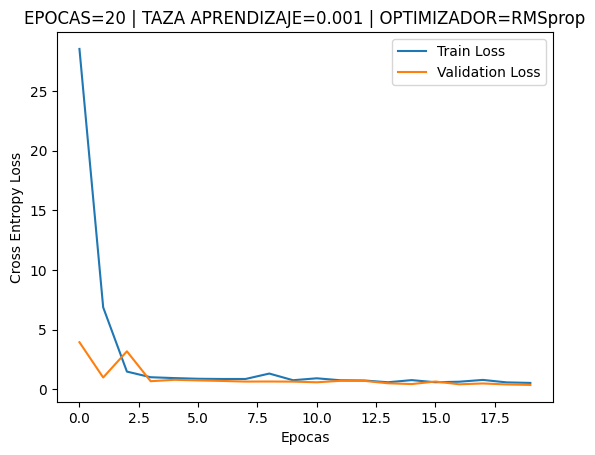

In [131]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 51.5622
Epoch [1/5]	Validation	Loss: 55.7602	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 40.1709
Epoch [2/5]	Validation	Loss: 59.8758	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 21.4407
Epoch [3/5]	Validation	Loss: 14.7461	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 13.8784
Epoch [4/5]	Validation	Loss: 14.3565	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 14.2243
Epoch [5/5]	Validation	Loss: 14.3754	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 14.3754
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


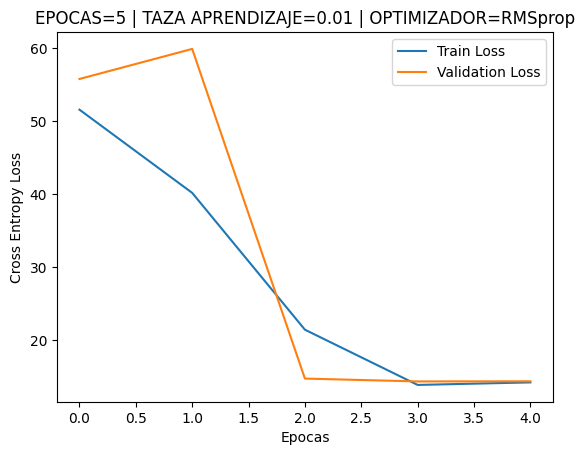

In [132]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 58.4093
Epoch [1/10]	Validation	Loss: 53.6986	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 55.8689
Epoch [2/10]	Validation	Loss: 53.4949	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 52.7048
Epoch [3/10]	Validation	Loss: 54.6054	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 57.1591
Epoch [4/10]	Validation	Loss: 51.5053	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 54.7757
Epoch [5/10]	Validation	Loss: 54.0332	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 54.3292
Epoch [6/10]	Validation	Loss: 56.8902	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 55.5506
Epoch [7/10]	Validation	Loss: 53.1641	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 53.3509
Epoch [8/10]	Validation	Loss: 55.3790	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 54.0677
Epoch [9/10]	Validation	Loss: 51.4759	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 5

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


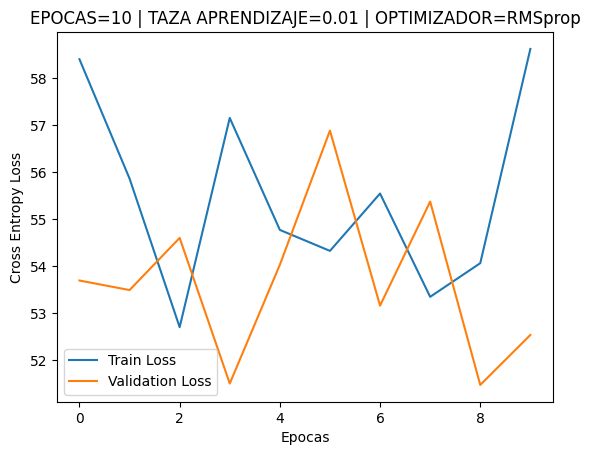

In [133]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 50.9503
Epoch [1/15]	Validation	Loss: 54.5512	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 55.3941
Epoch [2/15]	Validation	Loss: 56.1960	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 53.4330
Epoch [3/15]	Validation	Loss: 50.0755	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 56.9246
Epoch [4/15]	Validation	Loss: 56.2739	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 54.2344
Epoch [5/15]	Validation	Loss: 50.7070	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 54.5110
Epoch [6/15]	Validation	Loss: 57.1551	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 58.5007
Epoch [7/15]	Validation	Loss: 53.4732	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 53.8619
Epoch [8/15]	Validation	Loss: 56.4515	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 55.1344
Epoch [9/15]	Validation	Loss: 53.8453	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 58.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


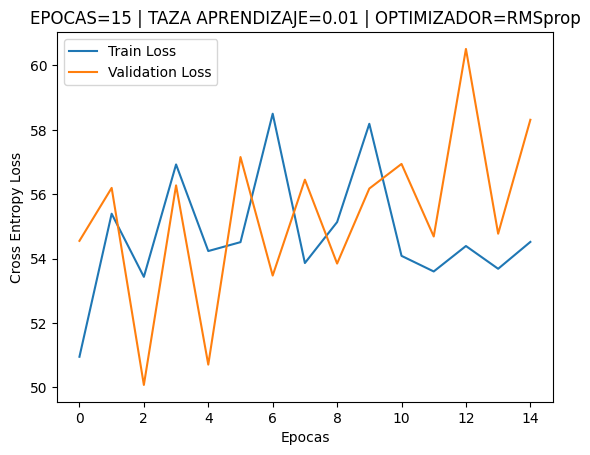

In [134]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 55.8703
Epoch [1/20]	Validation	Loss: 55.9118	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 54.2852
Epoch [2/20]	Validation	Loss: 53.3644	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 56.4925
Epoch [3/20]	Validation	Loss: 51.5699	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 54.4994
Epoch [4/20]	Validation	Loss: 52.4440	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 56.5919
Epoch [5/20]	Validation	Loss: 56.3124	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 55.4593
Epoch [6/20]	Validation	Loss: 48.7580	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 55.3004
Epoch [7/20]	Validation	Loss: 56.3685	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 56.2894
Epoch [8/20]	Validation	Loss: 52.3558	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 55.9805
Epoch [9/20]	Validation	Loss: 57.7657	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 55.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


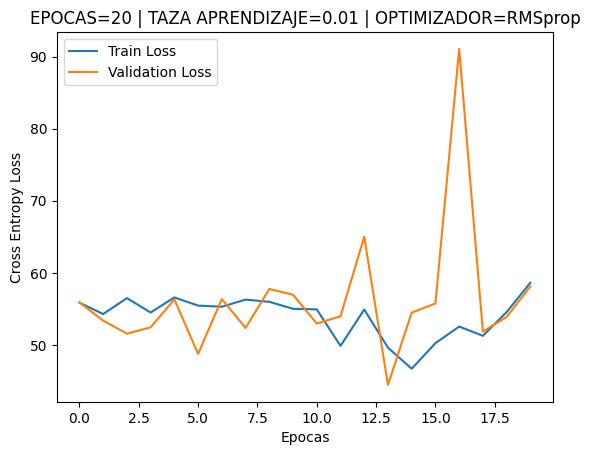

In [135]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 21.1362
Epoch [1/5]	Validation	Loss: 8.7958	Validation Accuracy: 56.0%
Epoch [2/5]	Training [40%]	Loss: 14.8706
Epoch [2/5]	Validation	Loss: 8.7823	Validation Accuracy: 55.0%
Epoch [3/5]	Training [60%]	Loss: 12.3292
Epoch [3/5]	Validation	Loss: 6.7009	Validation Accuracy: 56.5%
Epoch [4/5]	Training [80%]	Loss: 10.4285
Epoch [4/5]	Validation	Loss: 6.3490	Validation Accuracy: 59.0%
Epoch [5/5]	Training [100%]	Loss: 11.4778
Epoch [5/5]	Validation	Loss: 5.2163	Validation Accuracy: 56.0%
Performance on the test data:
	Loss: 5.2163
	Accuracy: 56.0%
	precision: 76.6%
	recall: 56.0%
	f_score: 45.4%
(0.7659574468085106, 0.56, 0.4543650793650793, None)

Confusion Matrix:
[[100   0]
 [ 88  12]]


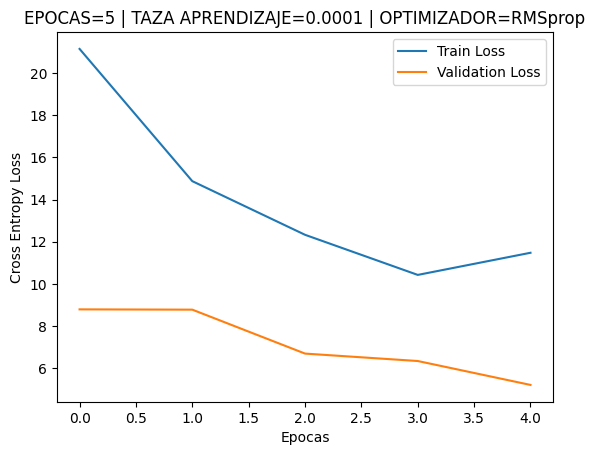

In [136]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 32.8107
Epoch [1/10]	Validation	Loss: 16.6466	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 25.0554
Epoch [2/10]	Validation	Loss: 18.0221	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 19.4285
Epoch [3/10]	Validation	Loss: 16.5783	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 21.4349
Epoch [4/10]	Validation	Loss: 20.6009	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 19.3901
Epoch [5/10]	Validation	Loss: 18.4488	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 20.8915
Epoch [6/10]	Validation	Loss: 15.3504	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 19.4268
Epoch [7/10]	Validation	Loss: 14.7938	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 19.2452
Epoch [8/10]	Validation	Loss: 16.5769	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 17.4066
Epoch [9/10]	Validation	Loss: 21.5747	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 1

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


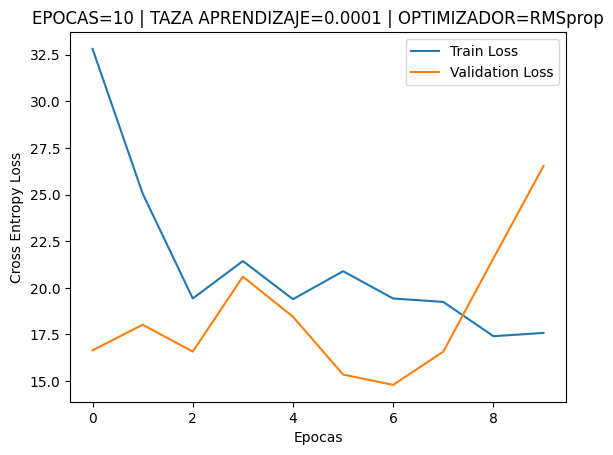

In [137]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 31.3612
Epoch [1/15]	Validation	Loss: 17.5116	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 23.9299
Epoch [2/15]	Validation	Loss: 16.8105	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 21.4772
Epoch [3/15]	Validation	Loss: 18.8292	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 21.8602
Epoch [4/15]	Validation	Loss: 14.3462	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 19.5800
Epoch [5/15]	Validation	Loss: 14.0809	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 18.6304
Epoch [6/15]	Validation	Loss: 13.3149	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 20.5546
Epoch [7/15]	Validation	Loss: 15.4923	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 18.1823
Epoch [8/15]	Validation	Loss: 22.3896	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 16.5511
Epoch [9/15]	Validation	Loss: 15.8202	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 16.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


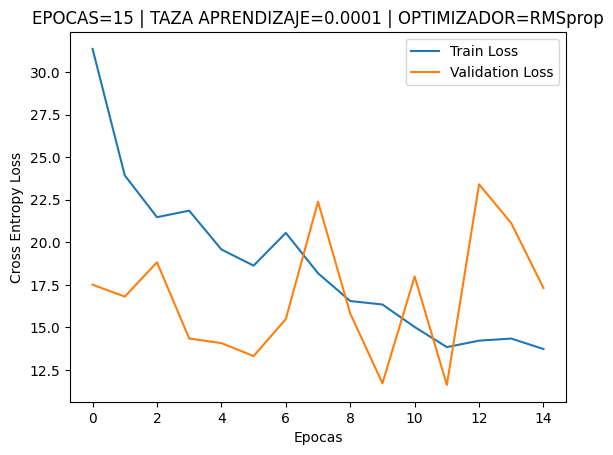

In [138]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 31.6404
Epoch [1/20]	Validation	Loss: 7.4552	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 10.0163
Epoch [2/20]	Validation	Loss: 6.3177	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 13.1866
Epoch [3/20]	Validation	Loss: 5.1533	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 11.3454
Epoch [4/20]	Validation	Loss: 4.5380	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 12.4291
Epoch [5/20]	Validation	Loss: 4.4541	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 9.0819
Epoch [6/20]	Validation	Loss: 3.6255	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 8.7429
Epoch [7/20]	Validation	Loss: 2.6180	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 8.1983
Epoch [8/20]	Validation	Loss: 2.4296	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 8.1421
Epoch [9/20]	Validation	Loss: 6.3884	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 9.5664
Epoch [10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


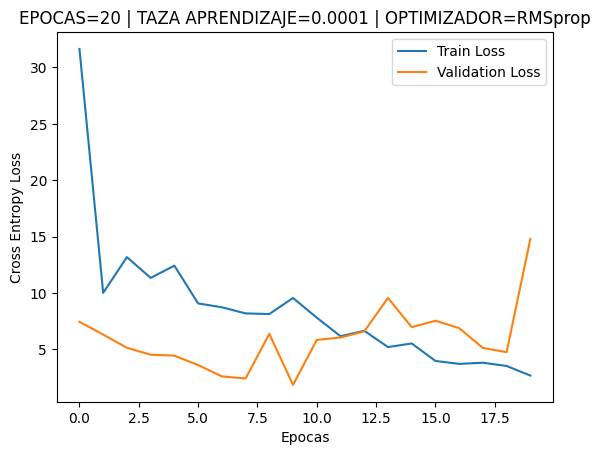

In [139]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------LBFGS--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 27.4040
Epoch [1/5]	Validation	Loss: 54.9249	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.0000
Epoch [2/5]	Validation	Loss: 54.7631	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.0000
Epoch [3/5]	Validation	Loss: 55.0051	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.0000
Epoch [4/5]	Validation	Loss: 55.2531	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 110.1480
Epoch [5/5]	Validation	Loss: 54.8779	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 54.8779
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


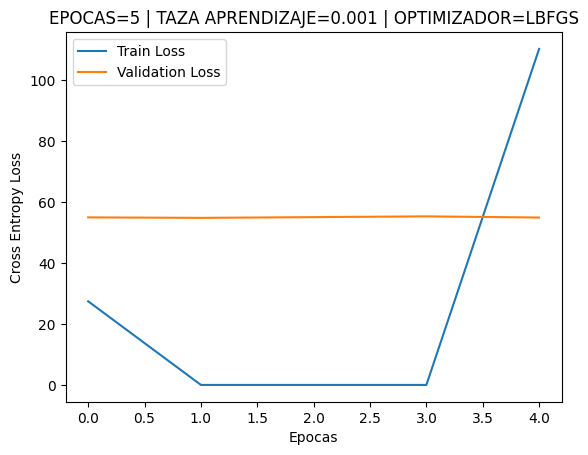

In [140]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 107.2060
Epoch [1/10]	Validation	Loss: 55.1128	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.0000
Epoch [2/10]	Validation	Loss: 54.6497	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 108.5140
Epoch [3/10]	Validation	Loss: 55.3577	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 107.0160
Epoch [4/10]	Validation	Loss: 55.0077	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 106.1100
Epoch [5/10]	Validation	Loss: 55.0594	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 106.6460
Epoch [6/10]	Validation	Loss: 55.3558	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 107.0720
Epoch [7/10]	Validation	Loss: 54.8501	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 0.0000
Epoch [8/10]	Validation	Loss: 54.8578	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 107.1680
Epoch [9/10]	Validation	Loss: 55.0154	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Lo

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


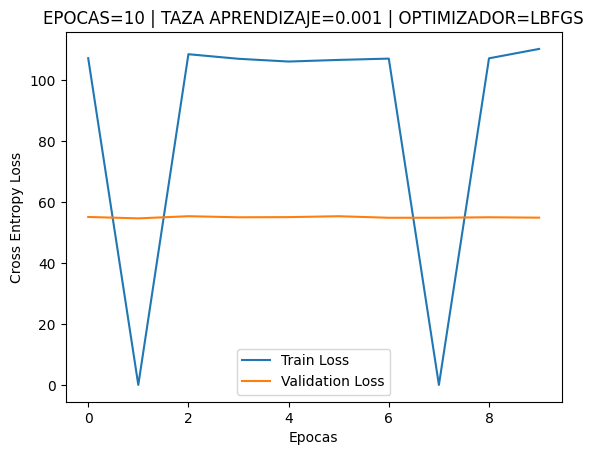

In [141]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.0000
Epoch [1/15]	Validation	Loss: 55.1621	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.0000
Epoch [2/15]	Validation	Loss: 55.4512	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 112.2420
Epoch [3/15]	Validation	Loss: 54.9826	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 107.6200
Epoch [4/15]	Validation	Loss: 55.0447	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 0.0000
Epoch [5/15]	Validation	Loss: 54.8677	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 109.2800
Epoch [6/15]	Validation	Loss: 55.3638	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 106.1100
Epoch [7/15]	Validation	Loss: 54.9827	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.0000
Epoch [8/15]	Validation	Loss: 54.9107	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 113.7240
Epoch [9/15]	Validation	Loss: 54.9950	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


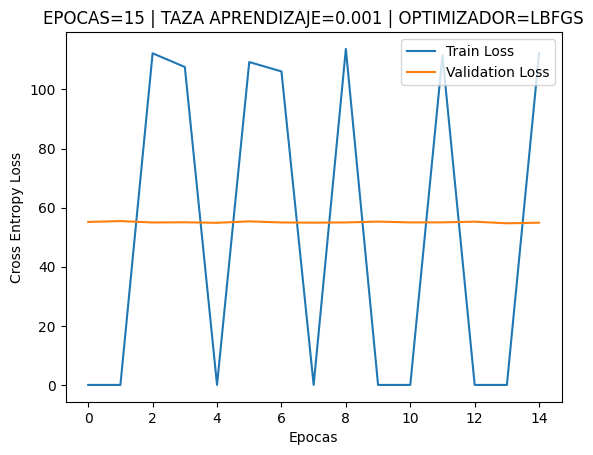

In [142]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 115.4540
Epoch [1/20]	Validation	Loss: 54.7704	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 107.6200
Epoch [2/20]	Validation	Loss: 55.2496	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0000
Epoch [3/20]	Validation	Loss: 55.0919	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 107.8800
Epoch [4/20]	Validation	Loss: 54.7847	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 111.5580
Epoch [5/20]	Validation	Loss: 54.8782	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.0000
Epoch [6/20]	Validation	Loss: 55.0825	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 0.0000
Epoch [7/20]	Validation	Loss: 55.0552	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.0000
Epoch [8/20]	Validation	Loss: 54.9731	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 105.6820
Epoch [9/20]	Validation	Loss: 54.9758	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 0.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


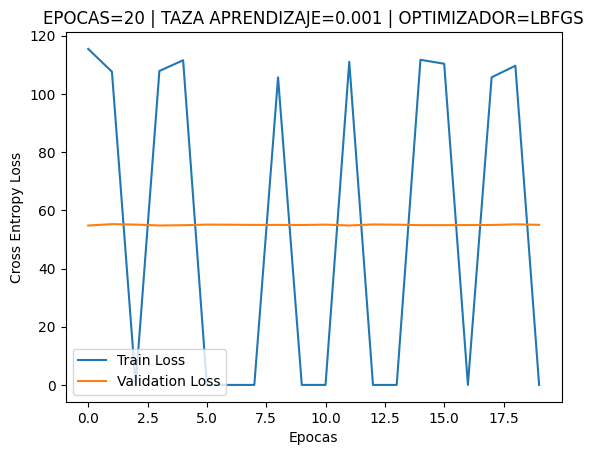

In [143]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 112.4620
Epoch [1/5]	Validation	Loss: 54.5958	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.0000
Epoch [2/5]	Validation	Loss: 54.9558	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 102.5760
Epoch [3/5]	Validation	Loss: 55.0130	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.0000
Epoch [4/5]	Validation	Loss: 55.0182	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 0.0000
Epoch [5/5]	Validation	Loss: 55.0242	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 55.0242
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


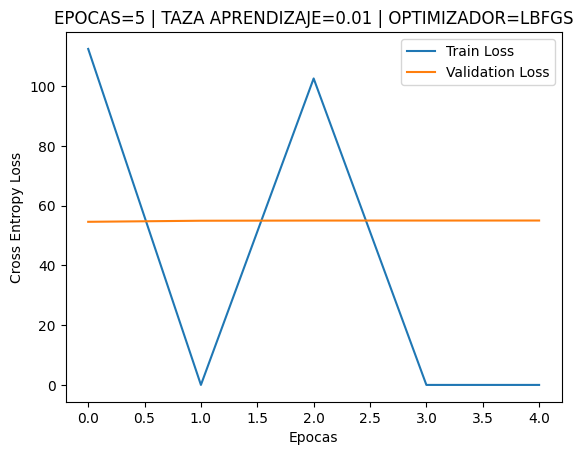

In [144]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 107.6200
Epoch [1/10]	Validation	Loss: 55.3373	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.0000
Epoch [2/10]	Validation	Loss: 54.7891	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 105.1320
Epoch [3/10]	Validation	Loss: 54.8517	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.0000
Epoch [4/10]	Validation	Loss: 54.9303	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 115.4400
Epoch [5/10]	Validation	Loss: 54.8577	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.0000
Epoch [6/10]	Validation	Loss: 55.0567	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 108.9460
Epoch [7/10]	Validation	Loss: 54.9751	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 113.0820
Epoch [8/10]	Validation	Loss: 54.9595	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 106.8620
Epoch [9/10]	Validation	Loss: 54.9527	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


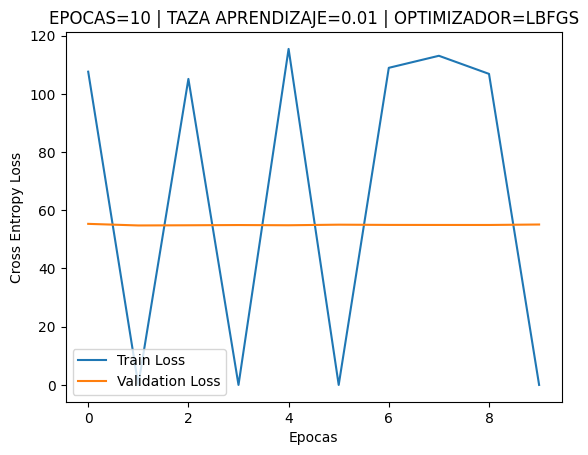

In [145]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 113.3260
Epoch [1/15]	Validation	Loss: 54.9855	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.0000
Epoch [2/15]	Validation	Loss: 55.2710	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 106.9660
Epoch [3/15]	Validation	Loss: 54.8924	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 0.0000
Epoch [4/15]	Validation	Loss: 55.2614	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 108.2120
Epoch [5/15]	Validation	Loss: 54.8643	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.0000
Epoch [6/15]	Validation	Loss: 54.8248	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 0.0000
Epoch [7/15]	Validation	Loss: 54.9753	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.0000
Epoch [8/15]	Validation	Loss: 55.0731	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 114.4560
Epoch [9/15]	Validation	Loss: 55.4573	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 104.

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


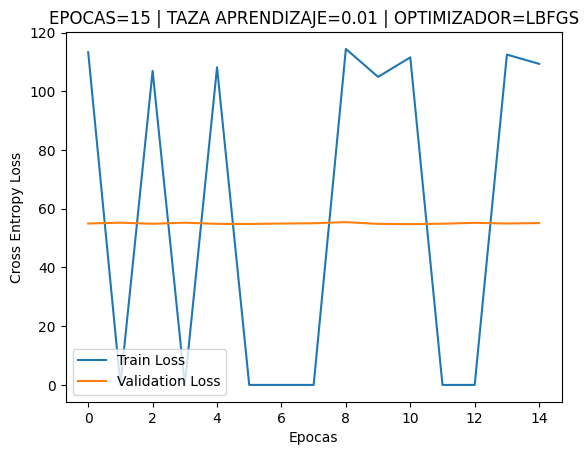

In [146]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 107.5920
Epoch [1/20]	Validation	Loss: 55.1051	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.0000
Epoch [2/20]	Validation	Loss: 54.9516	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0000
Epoch [3/20]	Validation	Loss: 54.9427	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.0000
Epoch [4/20]	Validation	Loss: 55.0619	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 0.0000
Epoch [5/20]	Validation	Loss: 55.1823	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 99.2480
Epoch [6/20]	Validation	Loss: 54.9110	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 110.3180
Epoch [7/20]	Validation	Loss: 55.0139	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.0000
Epoch [8/20]	Validation	Loss: 54.9040	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 0.0000
Epoch [9/20]	Validation	Loss: 55.2090	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 109.140

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


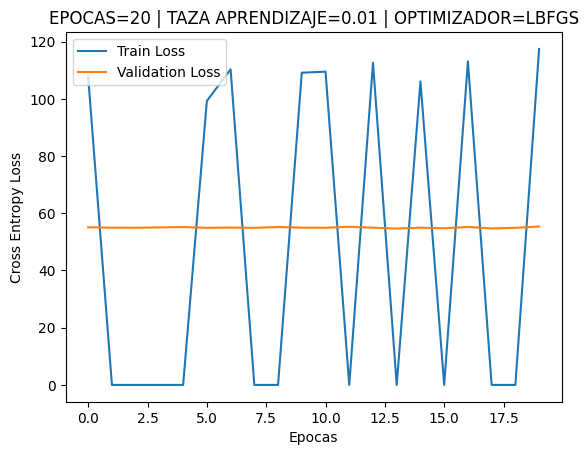

In [147]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.0000
Epoch [1/5]	Validation	Loss: 54.8307	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 110.2660
Epoch [2/5]	Validation	Loss: 54.9186	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.0000
Epoch [3/5]	Validation	Loss: 54.7182	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 113.8260
Epoch [4/5]	Validation	Loss: 54.9925	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 109.3020
Epoch [5/5]	Validation	Loss: 54.9371	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 54.9371
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


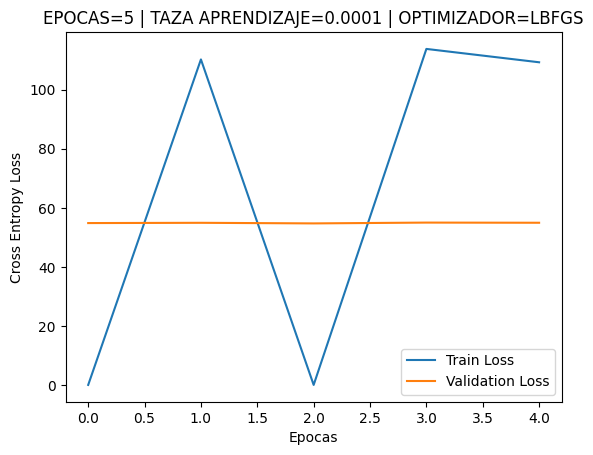

In [148]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.0000
Epoch [1/10]	Validation	Loss: 55.0980	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 113.7180
Epoch [2/10]	Validation	Loss: 54.9829	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 108.0940
Epoch [3/10]	Validation	Loss: 55.3012	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.0000
Epoch [4/10]	Validation	Loss: 55.1136	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 105.8240
Epoch [5/10]	Validation	Loss: 54.9815	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.0000
Epoch [6/10]	Validation	Loss: 54.9150	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.0000
Epoch [7/10]	Validation	Loss: 54.8748	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 108.5620
Epoch [8/10]	Validation	Loss: 55.0412	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 112.9380
Epoch [9/10]	Validation	Loss: 54.9176	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


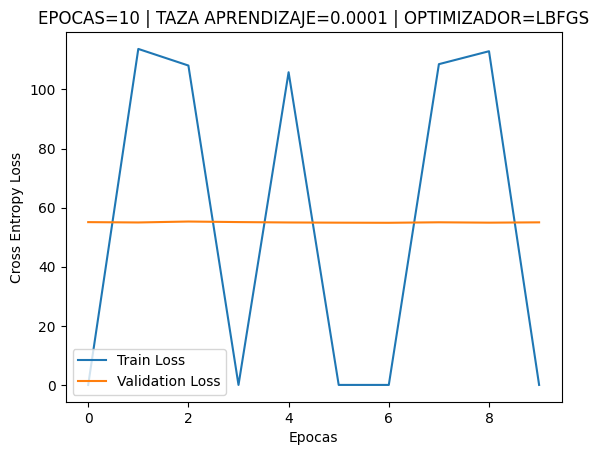

In [149]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 108.0620
Epoch [1/15]	Validation	Loss: 54.7452	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 107.6800
Epoch [2/15]	Validation	Loss: 54.9998	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.0000
Epoch [3/15]	Validation	Loss: 54.9468	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 109.3920
Epoch [4/15]	Validation	Loss: 54.9505	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 114.7200
Epoch [5/15]	Validation	Loss: 54.9470	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 113.4560
Epoch [6/15]	Validation	Loss: 54.9489	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 110.0420
Epoch [7/15]	Validation	Loss: 54.8713	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 110.1860
Epoch [8/15]	Validation	Loss: 55.0225	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 107.9700
Epoch [9/15]	Validation	Loss: 55.0728	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Lo

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


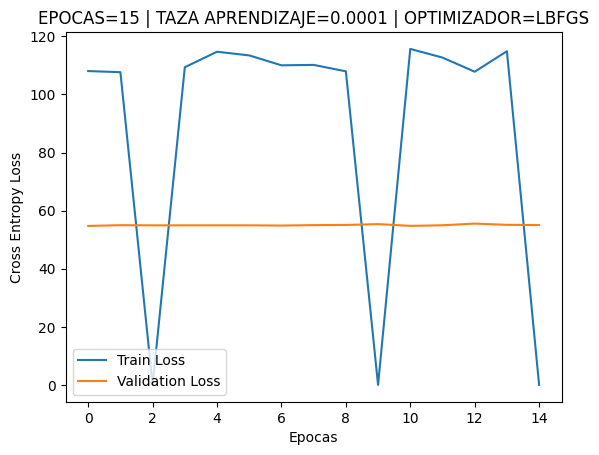

In [150]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 106.9920
Epoch [1/20]	Validation	Loss: 54.9242	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 114.0960
Epoch [2/20]	Validation	Loss: 54.8955	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0000
Epoch [3/20]	Validation	Loss: 54.5832	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.0000
Epoch [4/20]	Validation	Loss: 54.8076	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 103.0460
Epoch [5/20]	Validation	Loss: 54.8299	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.0000
Epoch [6/20]	Validation	Loss: 54.9322	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 107.1060
Epoch [7/20]	Validation	Loss: 54.9867	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.0000
Epoch [8/20]	Validation	Loss: 54.6915	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 107.6700
Epoch [9/20]	Validation	Loss: 55.1216	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 11

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


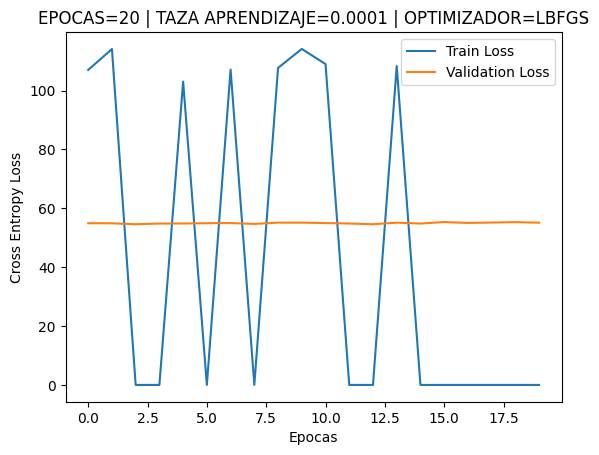

In [151]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [152]:
loss.item()

103.878

Testing the network

In [153]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valor real')
    plt.xlabel('Valor predecido')
    plt.tight_layout()

In [154]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9608\4116201098.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Performance on the test data:
	Loss: 54.8604
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)
Confusion matrix, without normalization
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


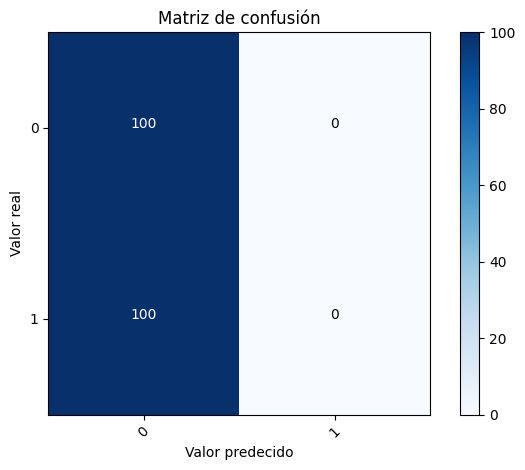

In [155]:
model.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Lists to store loss values
total_loss = []

# Loop through the test set
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Forward pass
        output = model(data)

        # Get predicted labels
        pred = output.argmax(dim=1, keepdim=True).view(-1)

        # Save true and predicted labels
        y_true.append(target.item())
        y_pred.append(pred.item())

        # Calculate loss (if needed)
        loss = loss_func(output, target)
        total_loss.append(loss.item())

# Print performance metrics
print('Performance on the test data:\n\tLoss: {:.4f}'.format(sum(total_loss) / len(total_loss)))

precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
# Calculate and print accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
print('\tprecision: {:.1f}%'.format(precision * 100))
print('\trecall: {:.1f}%'.format(recall * 100))
print('\tf_score: {:.1f}%'.format(f_score * 100))
print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
# Create and visualize the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, [0,1],normalize=False,title='Matriz de confusión',cmap=plt.cm.Blues)


In [156]:
print("acabo")

acabo
